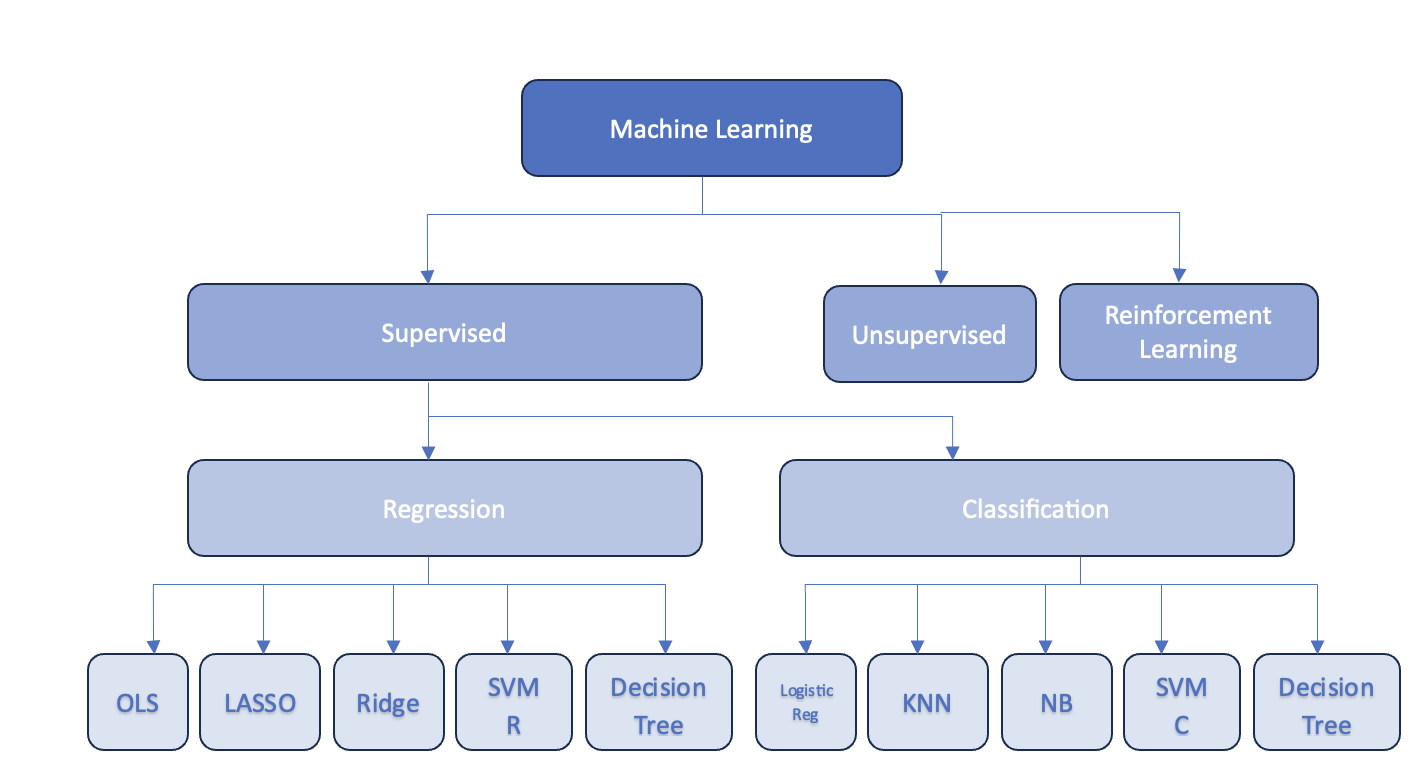

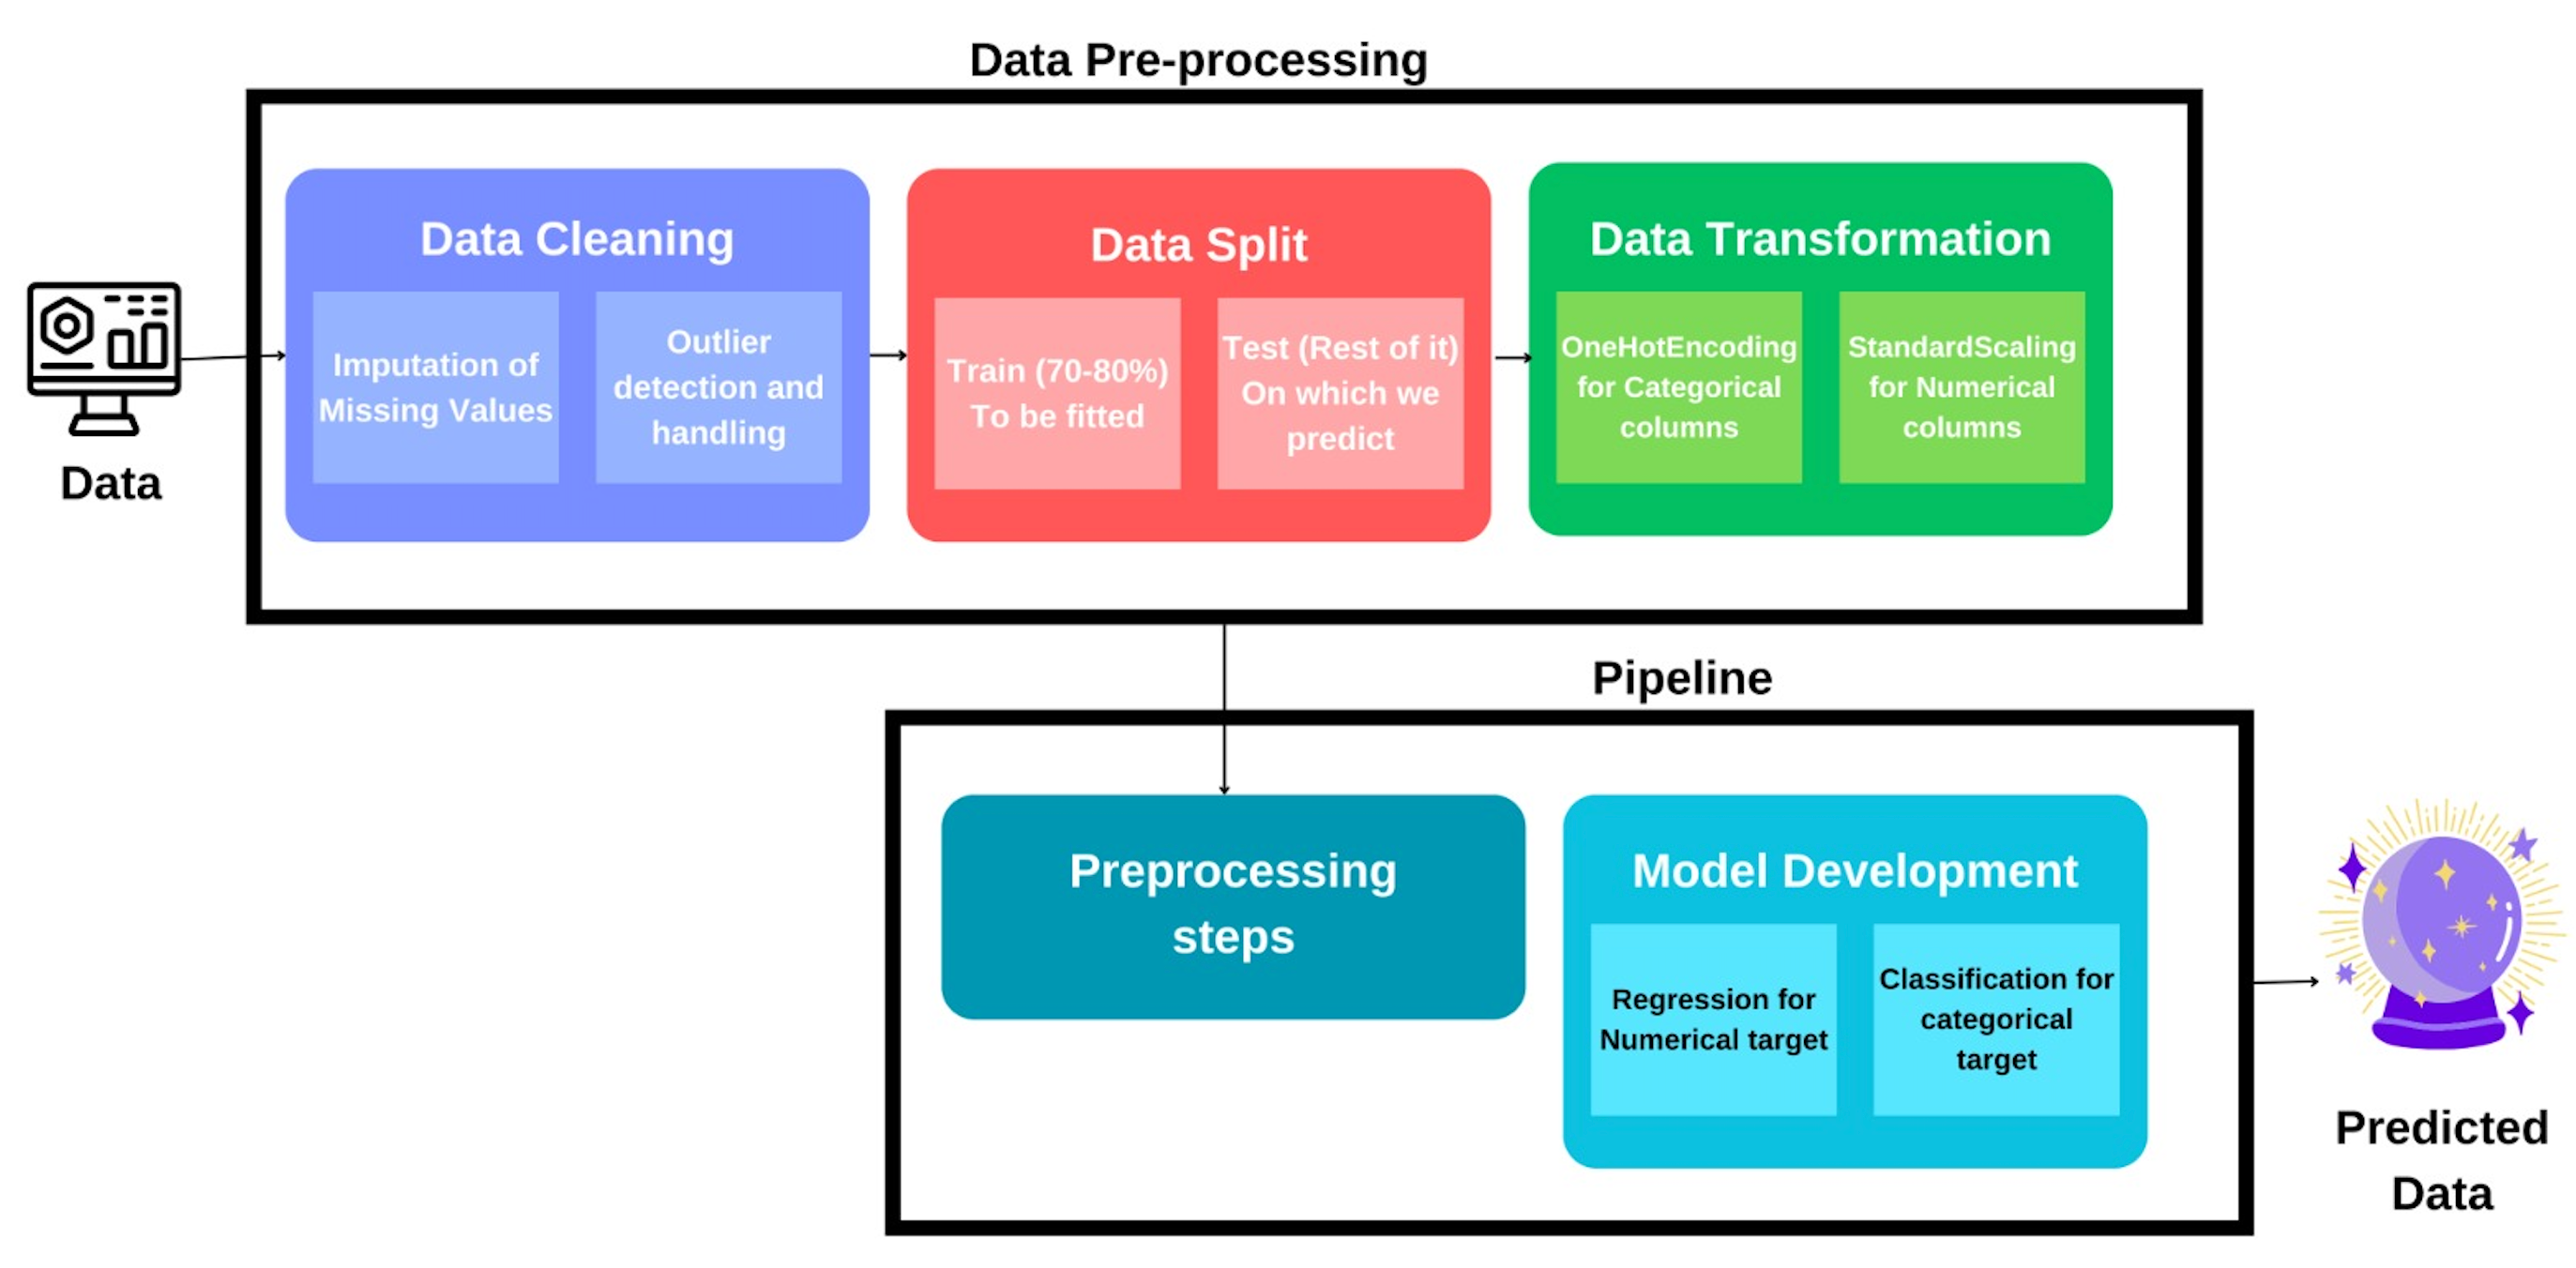

# Index:

- [Data Cleaning](#data-cleaning)
    - [Reviewing the Data frame](#reviewing-the-df)
    -  

# Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression



In [3]:
df = pd.read_csv('/Users/mahinbindra/Downloads/sales_data (2).csv')

In [4]:
df.head()

Product    Region   Price  Units Sold   Sale Date
0         NaN  Region_1   72.87        10.0  2022-01-01
1  Product_40  Region_2   46.19        10.0  2022-01-02
2   Product_1  Region_5     NaN         4.0  2022-01-03
3   Product_6  Region_8  143.47         8.0  2022-01-04
4  Product_44  Region_4  122.54        10.0  2022-01-05

### Reviewing the DF:
2 categorical columns - Region and Product
2 Numerical columns - Price and Units Sold
One Sale Date type column

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      942 non-null    object 
 2   Price       945 non-null    float64
 3   Units Sold  943 non-null    float64
 4   Sale Date   1050 non-null   object 
dtypes: float64(2), object(3)
memory usage: 41.1+ KB


### Lots of missing data^

In [6]:
df.describe(include='all')

Product    Region        Price  Units Sold   Sale Date
count         947       942   945.000000  943.000000        1050
unique         50        10          NaN         NaN        1000
top     Product_4  Region_5          NaN         NaN  2023-07-31
freq           30       112          NaN         NaN           2
mean          NaN       NaN   108.628011   10.200424         NaN
std           NaN       NaN   167.350086    3.247589         NaN
min           NaN       NaN     0.190000    2.000000         NaN
25%           NaN       NaN    26.420000    8.000000         NaN
50%           NaN       NaN    64.640000   10.000000         NaN
75%           NaN       NaN   142.310000   12.000000         NaN
max           NaN       NaN  2636.900000   22.000000         NaN

- Product has 50 unique values, with Product_4 being the most frequently occuring product, with 30 entries (~3% of all data)
- Region has 10 unique values, with Region_5 being the most frequently occuring region, with 112 entries (~10% of all data)
- The median Price is 108, which indicates skewness
- The maximum Price is $2,636 - this could be an outlier. We will need to investigate
- The median Units Sold is 10 and the mean Units Sold is also 10, which indicates a normal distribution
- The Sale Date has 1000 unique values, with the top value being '2023-07-31' occurring twice

Check if there are any rows with all columns as NaN

In [7]:
df.isna().all()

Product       False
Region        False
Price         False
Units Sold    False
Sale Date     False
dtype: bool

Check if there are any rows with important columns missing

In [8]:
df[df['Product'].isnull() & df['Region'].isnull() & df['Units Sold'].isnull()]

Product Region  Price  Units Sold   Sale Date
22     NaN    NaN  36.26         NaN  2022-01-23

In [9]:
df[df['Product'].isnull() & df['Region'].isnull() & df['Price'].isnull()]

Product Region  Price  Units Sold   Sale Date
7     NaN    NaN    NaN        11.0  2022-01-08

Drop both of these as they're useless to us

In [10]:
df.drop([7,22], axis=0, inplace=True)

In [11]:
df[df['Product'].isnull() & df['Region'].isnull()]

Product Region   Price  Units Sold   Sale Date
43       NaN    NaN   13.59        12.0  2022-02-13
228      NaN    NaN   24.35        10.0  2022-08-17
304      NaN    NaN    9.43         7.0  2022-11-01
318      NaN    NaN  305.21         9.0  2022-11-15
362      NaN    NaN  292.85         9.0  2022-12-29
604      NaN    NaN   49.04        13.0  2023-08-28
706      NaN    NaN  184.50         6.0  2023-12-08
842      NaN    NaN  200.61        12.0  2024-04-22
1006     NaN    NaN  292.85         9.0  2022-12-29
1016     NaN    NaN  200.61        12.0  2024-04-22

Just 10 entries so dropping these too

In [12]:
df.drop(df[df['Product'].isnull() & df['Region'].isnull()].index, axis=0, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     947 non-null    object 
 1   Region      942 non-null    object 
 2   Price       934 non-null    float64
 3   Units Sold  932 non-null    float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


## Imputation Options for categorical columns:
### 1. Option 1: Impute missing product and region with 'Other' category. 
df_test
### 2. Option 2: Impute missing product and region with the mode. 
df_test_2

From describe we can see the mode for product is Product_4 and for Region, its Region_5

We'll test both options to see which creates the least bias/difference in the describe stats.

In [14]:
#Option 1
df_test = df.copy()

In [15]:
df_test.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150  \
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   100.0  125.430300  263.248626  0.27  31.6175  75.195  141.4850   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00  \
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      103.0   9.941748  3.333800  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   18.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

In [16]:
df_test.groupby('Product').describe()

Price                                                              
           count        mean         std    min      25%      50%       75%   
Product                                                                       
Product_1   19.0   99.960526  108.592682   3.40  46.8550   75.880  107.4200  \
Product_10  17.0   97.610588   77.320574   3.63  36.2400   85.330  121.6500   
Product_11  12.0  120.550833   98.670114  21.70  61.6225   78.720  142.3325   
Product_12  14.0   77.138571   65.900566   2.37  30.6700   62.570  108.5425   
Product_13  17.0   88.629412   85.923571  12.86  18.2100   54.910  145.8400   
Product_14  10.0   95.544000  140.334625   4.15  17.6350   40.905  102.9875   
Product_15  19.0   89.121053  102.348294   5.71  24.2300   39.720  140.4600   
Product_16  13.0   77.116154  104.202676   4.52  11.2800   46.950   91.9800   
Product_17  21.0  127.157143   88.934104   5.39  54.6500  120.080  180.6100   
Product_18  11.0  107.107273  117.847272   1.90  18.7450   97.780  139.1000   
Product_19  20.0  115.748500   82.634176  16.82  46.6175   96.925  158.4750   
Product_2   17.0   79.284706   98.867995   8.80  24.8000   41.140   96.0300   
Product_20  15.0  110.592000  124.964054   9.09  21.6200   39.860  171.7950   
Product_21  14.0  110.399286  133.127824   0.19  16.6725   67.730  138.1200   
Product_22  18.0  130.213889  125.527139   7.59  48.8050   74.380  179.3050   
Product_23  20.0  130.509000  104.763169  11.00  35.3175   95.435  202.5500   
Product_24  25.0   57.740000   49.101278   0.25  26.3100   46.870   63.8700   
Product_25  13.0   79.464615   83.116307   1.96  10.2000   56.250  100.5700   
Product_26  16.0   90.234375   98.076628   8.76  31.7475   49.835  137.0575   
Product_27  21.0  193.255238  391.650662   1.96  24.0900   59.150  160.3400   
Product_28  20.0   78.497500   80.023828   4.20  22.1250   46.810  110.6975   
Product_29  14.0   82.186429   58.486838  10.39  33.4250   65.570  117.2300   
Product_3   21.0   93.558095   98.864401   7.57  20.8100   42.790  113.4700   
Product_30  15.0   85.231333   99.109780   3.61  27.0900   52.600   88.0400   
Product_31  20.0  128.834500  111.157886   1.60  25.1600   81.490  247.0900   
Product_32  10.0   74.437000   69.775829   1.66  26.4850   50.895  120.5650   
Product_33  16.0  114.543125  108.220983   7.97  45.6575   69.925  129.0250   
Product_34  17.0  253.598235  618.111915  20.51  53.7500  124.300  165.0900   
Product_35  11.0   47.802727   20.363126  17.20  34.9750   47.160   61.4100   
Product_36  18.0  103.420556   95.675373   0.27  26.7350   93.855  141.7100   
Product_37  17.0  105.664706  125.155765   4.31  23.3500   39.440  145.1000   
Product_38  19.0  100.138947   65.591971   7.46  44.8300   86.840  135.0000   
Product_39  12.0  104.623333  102.858955   1.46  11.5225   70.400  224.4300   
Product_4   29.0   99.022414   85.759042   6.02  24.5200   74.250  147.7800   
Product_40  26.0  111.934615  140.208123   2.91  27.3675   48.795  120.8150   
Product_41  11.0   70.522727   59.472020  13.16  20.7550   60.560  101.2550   
Product_42  19.0   90.431579   74.030503  17.44  28.7150   75.390  135.2600   
Product_43  25.0   73.047600   63.950752   0.27  27.3800   61.050   91.8200   
Product_44  15.0  120.669333  137.578457   0.19  28.2650   83.330  116.2700   
Product_45  14.0  104.425714   88.948415   6.20  34.5400   86.365  152.4725   
Product_46  15.0  120.521333  125.516603   0.71  38.9150   87.660  133.6500   
Product_47  10.0   68.001000   44.358792  13.46  33.5250   59.535  112.5975   
Product_48  14.0   66.525714   67.226234   6.22  23.1050   51.840   73.0550   
Product_49  21.0  165.538095  268.610528  14.87  51.9300   96.060  168.3600   
Product_5   13.0   77.390000   69.412601   2.06  18.8000   49.530  150.8700   
Product_50  25.0  179.963600  156.803329  19.74  68.1600  144.470  223.8100   
Product_6   16.0   90.030000   89.634786  22.76  28.8200   63.025  107.4125   
Product_7   18.0  111.477778  133.009464   5.79  37.3375   60

In [17]:
df_test['Region'] = df_test['Region'].fillna('Other')
df_test['Product'] = df_test['Product'].fillna('Other')

In [18]:
df_test.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Other       87.0  107.890690  117.639895  1.46  21.4350  56.250  162.3150  \
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150   
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   100.0  125.430300  263.248626  0.27  31.6175  75.195  141.4850   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Other       570.60       88.0   9.931818  3.303761  3.0  7.00  10.0  12.00  \
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00   
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      103.0   9.941748  3.333800  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Other      19.0  
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   18.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

Stats for Other are vv similar to other regions i.e. not much bias. 

In [19]:
df_test.groupby('Product').describe()

Price                                                              
           count        mean         std    min      25%      50%       75%   
Product                                                                       
Other       81.0  132.646790  293.502959   0.27  17.9000   64.600  147.4700  \
Product_1   19.0   99.960526  108.592682   3.40  46.8550   75.880  107.4200   
Product_10  17.0   97.610588   77.320574   3.63  36.2400   85.330  121.6500   
Product_11  12.0  120.550833   98.670114  21.70  61.6225   78.720  142.3325   
Product_12  14.0   77.138571   65.900566   2.37  30.6700   62.570  108.5425   
Product_13  17.0   88.629412   85.923571  12.86  18.2100   54.910  145.8400   
Product_14  10.0   95.544000  140.334625   4.15  17.6350   40.905  102.9875   
Product_15  19.0   89.121053  102.348294   5.71  24.2300   39.720  140.4600   
Product_16  13.0   77.116154  104.202676   4.52  11.2800   46.950   91.9800   
Product_17  21.0  127.157143   88.934104   5.39  54.6500  120.080  180.6100   
Product_18  11.0  107.107273  117.847272   1.90  18.7450   97.780  139.1000   
Product_19  20.0  115.748500   82.634176  16.82  46.6175   96.925  158.4750   
Product_2   17.0   79.284706   98.867995   8.80  24.8000   41.140   96.0300   
Product_20  15.0  110.592000  124.964054   9.09  21.6200   39.860  171.7950   
Product_21  14.0  110.399286  133.127824   0.19  16.6725   67.730  138.1200   
Product_22  18.0  130.213889  125.527139   7.59  48.8050   74.380  179.3050   
Product_23  20.0  130.509000  104.763169  11.00  35.3175   95.435  202.5500   
Product_24  25.0   57.740000   49.101278   0.25  26.3100   46.870   63.8700   
Product_25  13.0   79.464615   83.116307   1.96  10.2000   56.250  100.5700   
Product_26  16.0   90.234375   98.076628   8.76  31.7475   49.835  137.0575   
Product_27  21.0  193.255238  391.650662   1.96  24.0900   59.150  160.3400   
Product_28  20.0   78.497500   80.023828   4.20  22.1250   46.810  110.6975   
Product_29  14.0   82.186429   58.486838  10.39  33.4250   65.570  117.2300   
Product_3   21.0   93.558095   98.864401   7.57  20.8100   42.790  113.4700   
Product_30  15.0   85.231333   99.109780   3.61  27.0900   52.600   88.0400   
Product_31  20.0  128.834500  111.157886   1.60  25.1600   81.490  247.0900   
Product_32  10.0   74.437000   69.775829   1.66  26.4850   50.895  120.5650   
Product_33  16.0  114.543125  108.220983   7.97  45.6575   69.925  129.0250   
Product_34  17.0  253.598235  618.111915  20.51  53.7500  124.300  165.0900   
Product_35  11.0   47.802727   20.363126  17.20  34.9750   47.160   61.4100   
Product_36  18.0  103.420556   95.675373   0.27  26.7350   93.855  141.7100   
Product_37  17.0  105.664706  125.155765   4.31  23.3500   39.440  145.1000   
Product_38  19.0  100.138947   65.591971   7.46  44.8300   86.840  135.0000   
Product_39  12.0  104.623333  102.858955   1.46  11.5225   70.400  224.4300   
Product_4   29.0   99.022414   85.759042   6.02  24.5200   74.250  147.7800   
Product_40  26.0  111.934615  140.208123   2.91  27.3675   48.795  120.8150   
Product_41  11.0   70.522727   59.472020  13.16  20.7550   60.560  101.2550   
Product_42  19.0   90.431579   74.030503  17.44  28.7150   75.390  135.2600   
Product_43  25.0   73.047600   63.950752   0.27  27.3800   61.050   91.8200   
Product_44  15.0  120.669333  137.578457   0.19  28.2650   83.330  116.2700   
Product_45  14.0  104.425714   88.948415   6.20  34.5400   86.365  152.4725   
Product_46  15.0  120.521333  125.516603   0.71  38.9150   87.660  133.6500   
Product_47  10.0   68.001000   44.358792  13.46  33.5250   59.535  112.5975   
Product_48  14.0   66.525714   67.226234   6.22  23.1050   51.840   73.0550   
Product_49  21.0  165.538095  268.610528  14.87  51.9300   96.060  168.3600   
Product_5   13.0   77.390000   69.412601   2.06  18.8000   49.530  150.8700   
Product_50  25.0  179.963600  156.803329  19.74  68.1600  144.470  223.8100   
Product_6   16.0   90.030000   89.634786  22.76  28.8200   63

"Other" has a sufficiently higher product count than the rest of the products. Also the mean, stdev, and other metrics for Price seem to be quite different so creates a bias. 

### Option 1: Acceptable for Region but rejected for Product

In [20]:
#Option 2
df_test_2 = df.copy()

In [21]:
df_test_2['Region'] = df_test_2['Region'].fillna('Region_5')
df_test_2['Product'] = df_test_2['Product'].fillna('Product_4')

In [22]:
df_test_2.groupby('Region').describe()

Price                                                            
           count        mean         std   min      25%     50%       75%   
Region                                                                      
Region_1    78.0   97.792821   89.277140  2.91  40.7575  72.440  121.2150  \
Region_10   80.0  113.310500  120.292908  0.19  26.7425  67.900  151.6175   
Region_2    94.0  137.287340  283.069362  1.49  24.4725  66.960  158.7025   
Region_3    75.0   91.008400   89.612608  3.40  35.1000  58.370  121.1550   
Region_4    79.0   85.824051   94.673327  2.37  21.3050  47.340  119.8500   
Region_5   187.0  117.270160  208.233263  0.27  26.8850  68.150  151.5300   
Region_6    81.0   96.727037   98.491166  0.71  28.7300  55.410  125.5100   
Region_7    84.0  107.210119  211.396135  0.19  20.1225  58.865  123.8175   
Region_8    88.0  120.850909  158.015038  0.27  38.8225  81.585  145.4825   
Region_9    88.0   95.861477   98.457933  0.25  23.6950  66.375  134.7675   

                   Units Sold                                                
               max      count       mean       std  min   25%   50%    75%   
Region                                                                       
Region_1    469.65       82.0  10.329268  3.527860  2.0  8.00  10.5  13.00  \
Region_10   650.50       81.0   9.814815  3.369388  4.0  8.00  10.0  12.00   
Region_2   2636.90       92.0  10.413043  2.875253  5.0  8.75  10.0  12.00   
Region_3    485.84       78.0   9.807692  3.137779  4.0  8.00  10.0  11.75   
Region_4    489.40       79.0  10.227848  3.108918  2.0  8.00  10.0  12.00   
Region_5   2544.60      191.0   9.937173  3.311262  3.0  7.00  10.0  12.00   
Region_6    417.05       71.0  10.394366  2.983186  4.0  9.00  10.0  12.00   
Region_7   1793.90       85.0  10.894118  3.712987  3.0  8.00  11.0  13.00   
Region_8   1296.00       84.0  10.642857  3.364030  3.0  8.75  11.0  12.25   
Region_9    531.91       89.0   9.887640  2.994078  5.0  7.00  10.0  12.00   

                 
            max  
Region           
Region_1   21.0  
Region_10  19.0  
Region_2   17.0  
Region_3   18.0  
Region_4   16.0  
Region_5   19.0  
Region_6   18.0  
Region_7   22.0  
Region_8   20.0  
Region_9   18.0

Region 5's stats changed drastically i.e. creates bias 

In [23]:
df_test_2.groupby('Product').describe()

Price                                                              
            count        mean         std    min      25%      50%       75%   
Product                                                                        
Product_1    19.0   99.960526  108.592682   3.40  46.8550   75.880  107.4200  \
Product_10   17.0   97.610588   77.320574   3.63  36.2400   85.330  121.6500   
Product_11   12.0  120.550833   98.670114  21.70  61.6225   78.720  142.3325   
Product_12   14.0   77.138571   65.900566   2.37  30.6700   62.570  108.5425   
Product_13   17.0   88.629412   85.923571  12.86  18.2100   54.910  145.8400   
Product_14   10.0   95.544000  140.334625   4.15  17.6350   40.905  102.9875   
Product_15   19.0   89.121053  102.348294   5.71  24.2300   39.720  140.4600   
Product_16   13.0   77.116154  104.202676   4.52  11.2800   46.950   91.9800   
Product_17   21.0  127.157143   88.934104   5.39  54.6500  120.080  180.6100   
Product_18   11.0  107.107273  117.847272   1.90  18.7450   97.780  139.1000   
Product_19   20.0  115.748500   82.634176  16.82  46.6175   96.925  158.4750   
Product_2    17.0   79.284706   98.867995   8.80  24.8000   41.140   96.0300   
Product_20   15.0  110.592000  124.964054   9.09  21.6200   39.860  171.7950   
Product_21   14.0  110.399286  133.127824   0.19  16.6725   67.730  138.1200   
Product_22   18.0  130.213889  125.527139   7.59  48.8050   74.380  179.3050   
Product_23   20.0  130.509000  104.763169  11.00  35.3175   95.435  202.5500   
Product_24   25.0   57.740000   49.101278   0.25  26.3100   46.870   63.8700   
Product_25   13.0   79.464615   83.116307   1.96  10.2000   56.250  100.5700   
Product_26   16.0   90.234375   98.076628   8.76  31.7475   49.835  137.0575   
Product_27   21.0  193.255238  391.650662   1.96  24.0900   59.150  160.3400   
Product_28   20.0   78.497500   80.023828   4.20  22.1250   46.810  110.6975   
Product_29   14.0   82.186429   58.486838  10.39  33.4250   65.570  117.2300   
Product_3    21.0   93.558095   98.864401   7.57  20.8100   42.790  113.4700   
Product_30   15.0   85.231333   99.109780   3.61  27.0900   52.600   88.0400   
Product_31   20.0  128.834500  111.157886   1.60  25.1600   81.490  247.0900   
Product_32   10.0   74.437000   69.775829   1.66  26.4850   50.895  120.5650   
Product_33   16.0  114.543125  108.220983   7.97  45.6575   69.925  129.0250   
Product_34   17.0  253.598235  618.111915  20.51  53.7500  124.300  165.0900   
Product_35   11.0   47.802727   20.363126  17.20  34.9750   47.160   61.4100   
Product_36   18.0  103.420556   95.675373   0.27  26.7350   93.855  141.7100   
Product_37   17.0  105.664706  125.155765   4.31  23.3500   39.440  145.1000   
Product_38   19.0  100.138947   65.591971   7.46  44.8300   86.840  135.0000   
Product_39   12.0  104.623333  102.858955   1.46  11.5225   70.400  224.4300   
Product_4   110.0  123.782182  255.608494   0.27  21.6225   65.410  147.7025   
Product_40   26.0  111.934615  140.208123   2.91  27.3675   48.795  120.8150   
Product_41   11.0   70.522727   59.472020  13.16  20.7550   60.560  101.2550   
Product_42   19.0   90.431579   74.030503  17.44  28.7150   75.390  135.2600   
Product_43   25.0   73.047600   63.950752   0.27  27.3800   61.050   91.8200   
Product_44   15.0  120.669333  137.578457   0.19  28.2650   83.330  116.2700   
Product_45   14.0  104.425714   88.948415   6.20  34.5400   86.365  152.4725   
Product_46   15.0  120.521333  125.516603   0.71  38.9150   87.660  133.6500   
Product_47   10.0   68.001000   44.358792  13.46  33.5250   59.535  112.5975   
Product_48   14.0   66.525714   67.226234   6.22  23.1050   51.840   73.0550   
Product_49   21.0  165.538095  268.610528  14.87  51.9300   96.060  168.3600   
Product_5    13.0   77.390000   69.412601   2.06  18.8000   49.530  150.8700   
Product_50   25.0  179.963600  156.803329  19.74  68.1600  144.470  223.8100   
Product_6    16.0   90.030000   89.634786  22.76  28.8200   63.025  107.4125   
Product_7   

Product_4's stats changed quite a bit i.e. creates a bias
### Option2: Rejected for both Product and Region

### Devise Option 3: Impute Randomly

In [24]:
df_test_3 = df.copy()

In [25]:
products = df['Product'].unique()

In [26]:
products

array([nan, 'Product_40', 'Product_1', 'Product_6', 'Product_44',
       'Product_21', 'Product_31', 'Product_20', 'Product_34',
       'Product_3', 'Product_35', 'Product_50', 'Product_4', 'Product_19',
       'Product_23', 'Product_13', 'Product_9', 'Product_48',
       'Product_26', 'Product_42', 'Product_14', 'Product_5',
       'Product_37', 'Product_12', 'Product_8', 'Product_39',
       'Product_17', 'Product_29', 'Product_47', 'Product_36',
       'Product_43', 'Product_16', 'Product_32', 'Product_10',
       'Product_15', 'Product_27', 'Product_22', 'Product_28',
       'Product_45', 'Product_25', 'Product_11', 'Product_46',
       'Product_2', 'Product_33', 'Product_49', 'Product_24',
       'Product_41', 'Product_18', 'Product_7', 'Product_30',
       'Product_38'], dtype=object)

In [27]:
#Remove nan from this list 
products = products[1:]

In [28]:
missing = df_test_3['Product'].isnull().sum()
missing

91

In [29]:
random = np.random.choice(products,size=missing)
random

array(['Product_3', 'Product_13', 'Product_4', 'Product_4', 'Product_23',
       'Product_8', 'Product_23', 'Product_29', 'Product_46', 'Product_7',
       'Product_14', 'Product_50', 'Product_11', 'Product_29',
       'Product_50', 'Product_9', 'Product_14', 'Product_24',
       'Product_35', 'Product_49', 'Product_22', 'Product_3',
       'Product_20', 'Product_39', 'Product_1', 'Product_14', 'Product_2',
       'Product_47', 'Product_11', 'Product_36', 'Product_46',
       'Product_42', 'Product_12', 'Product_45', 'Product_34',
       'Product_44', 'Product_46', 'Product_13', 'Product_35',
       'Product_6', 'Product_40', 'Product_34', 'Product_22', 'Product_3',
       'Product_4', 'Product_18', 'Product_44', 'Product_17',
       'Product_37', 'Product_27', 'Product_35', 'Product_7',
       'Product_13', 'Product_7', 'Product_7', 'Product_30', 'Product_39',
       'Product_46', 'Product_17', 'Product_14', 'Product_34',
       'Product_35', 'Product_34', 'Product_4', 'Product_4', 'P

In [30]:
df_test_3.loc[df_test_3['Product'].isnull(),'Product'] = random

In [31]:
df_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     1038 non-null   object 
 1   Region      942 non-null    object 
 2   Price       934 non-null    float64
 3   Units Sold  932 non-null    float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


In [32]:
df_test_3.groupby('Product').describe().describe()

Price                                                             
          count        mean         std        min        25%         50%   
count  50.00000   50.000000   50.000000  50.000000  50.000000   50.000000  \
mean   18.68000  105.122765  123.798333   6.426200  29.893850   67.178700   
std     4.69233   38.323616  106.463793   6.084296  12.351971   24.086875   
min    10.00000   46.600000   23.782999   0.190000  10.200000   26.160000   
25%    15.00000   79.374683   80.866403   1.735000  22.282500   50.358750   
50%    18.50000   98.658869   99.505558   4.415000  27.235000   62.200000   
75%    21.00000  119.512381  123.623236   9.007500  36.806875   75.742500   
max    33.00000  234.398095  584.864911  22.760000  68.160000  144.470000   

                               Units Sold                                    
              75%          max      count       mean        std        min   
count   50.000000    50.000000  50.000000  50.000000  50.000000  50.000000  \
mean   134.517800   480.636800  18.640000  10.217532   3.209287   4.820000   
std     40.133859   512.638309   4.355433   0.811571   0.551203   1.288727   
min     64.410000    86.420000  12.000000   8.714286   1.815683   2.000000   
25%    106.200625   260.647500  15.000000   9.764444   2.902526   4.000000   
50%    130.843750   346.340000  18.000000  10.236111   3.221173   5.000000   
75%    147.586250   466.712500  21.000000  10.707589   3.533320   5.750000   
max    247.090000  2636.900000  29.000000  12.769231   4.813557   7.000000   

                                                   
             25%        50%        75%        max  
count  50.000000  50.000000  50.000000  50.000000  
mean    8.245000  10.130000  12.300000  16.400000  
std     1.076761   0.978389   1.166059   2.166536  
min     6.500000   8.000000  10.000000  12.000000  
25%     7.250000   9.625000  11.750000  15.000000  
50%     8.000000  10.000000  12.250000  16.000000  
75%     9.000000  11.000000  13.000000  17.000000  
max    11.000000  12.500000  14.000000  22.000000

In [33]:
df.groupby('Product').describe().describe()

Price                                                             
           count        mean         std        min        25%         50%   
count  50.000000   50.000000   50.000000  50.000000  50.000000   50.000000  \
mean   17.060000  103.389360  115.206717   7.087200  30.640250   67.791900   
std     4.469443   35.445971   91.409903   6.344425  13.205322   23.854109   
min    10.000000   47.802727   20.363126   0.190000  10.200000   39.440000   
25%    14.000000   79.927350   77.996387   1.960000  22.370000   48.978750   
50%    17.000000   98.316501   98.767258   5.550000  27.291250   61.810000   
75%    20.000000  113.890998  125.107838  10.065000  36.009375   82.870000   
max    29.000000  253.598235  618.111915  22.760000  68.160000  144.470000   

                               Units Sold                                    
              75%          max      count       mean        std        min   
count   50.000000    50.000000   50.00000  50.000000  50.000000  50.000000  \
mean   132.321350   425.171000   17.00000  10.248956   3.243557   4.860000   
std     39.939598   418.424253    4.15024   0.831098   0.549240   1.293784   
min     61.410000    86.420000   11.00000   8.684211   1.877669   2.000000   
25%    107.700625   256.300000   13.00000   9.763182   2.858010   4.000000   
50%    131.337500   318.505000   16.50000  10.263285   3.222235   5.000000   
75%    150.097500   415.245000   19.00000  10.723077   3.568173   6.000000   
max    247.090000  2636.900000   28.00000  12.916667   4.813557   7.000000   

                                                   
             25%        50%        75%        max  
count  50.000000  50.000000  50.000000  50.000000  
mean    8.190000  10.130000  12.340000  16.320000  
std     1.061333   1.034161   1.194972   2.161254  
min     6.250000   8.000000  10.000000  12.000000  
25%     7.250000   9.625000  11.812500  15.000000  
50%     8.000000  10.000000  12.500000  16.000000  
75%     9.000000  11.000000  13.000000  17.000000  
max    11.000000  12.500000  14.250000  22.000000

Compare these 2 tables side by side: Differences not as drastic as before so 
### Option 3: Acceptable for product

Note: if none of the approaches fit and the missing data is less than 10%, drop it. 

## Apply Option 1 to df for Region and Option 3 to df for Product

In [34]:
df['Region'] = df['Region'].fillna('Other')
df.loc[df['Product'].isnull(), 'Product'] = random

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     1038 non-null   object 
 1   Region      1038 non-null   object 
 2   Price       934 non-null    float64
 3   Units Sold  932 non-null    float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


## Imputation Options for Continuous columns 

Choose mean or median as the imputed value by looking the describe stats of the column. If mean and median are similar then choose mean. If lots of outliers, choose median. 

If you can't choose, pick both theories and see how data changes. 

Once you have decided, choose if you should impute with mean/median of entire df, by one category or by another category. 

In this case, we're choosing median for price and units sold with 3 options:
- Option 1: Median of whole column
- Option 2: Median by each product
- Option 3: Median by each region

In [36]:
#Option 1
df_test['Price'] = df_test['Price'].fillna(df_test['Price'].median())
df_test['Units Sold'] = df_test['Units Sold'].fillna(df_test['Units Sold'].median())

#Option 2
df_test_2['Price'] = df_test_2['Price'].fillna(df_test_2.groupby('Product')['Price'].transform('median'))
df_test_2['Units Sold'] = df_test_2['Units Sold'].fillna(df_test_2['Units Sold'].median())

#Option 3
df_test_3['Price'] = df_test_3['Price'].fillna(df_test_3.groupby('Region')['Price'].transform('median'))
df_test_3['Units Sold'] = df_test_3['Units Sold'].fillna(df_test_3['Units Sold'].median())

In [37]:
df_test.describe()

Price   Units Sold
count  1038.000000  1038.000000
mean    103.819509    10.182081
std     159.710346     3.088003
min       0.190000     2.000000
25%      30.267500     8.000000
50%      64.620000    10.000000
75%     128.782500    12.000000
max    2636.900000    22.000000

In [38]:
df_test_2.describe()

Price   Units Sold
count  1038.000000  1038.000000
mean    104.010877    10.182081
std     159.798364     3.088003
min       0.190000     2.000000
25%      30.267500     8.000000
50%      64.620000    10.000000
75%     128.782500    12.000000
max    2636.900000    22.000000

In [39]:
df_test_3.describe()

Price   Units Sold
count  1029.000000  1038.000000
mean    104.206540    10.182081
std     160.382889     3.088003
min       0.190000     2.000000
25%      30.040000     8.000000
50%      66.375000    10.000000
75%     130.120000    12.000000
max    2636.900000    22.000000

In [40]:
df.describe()

Price  Units Sold
count   934.000000  932.000000
mean    108.184336   10.202790
std     167.810334    3.258414
min       0.190000    2.000000
25%      26.442500    8.000000
50%      64.620000   10.000000
75%     141.150000   12.000000
max    2636.900000   22.000000

For Price: Both 1 and 2 maintained median but option3 median dropped but just a lil bit - its ok to fill with median of the entire column
For Units Sold: Not much difference between all choices so fill in with the median of entire column
### Accept Option 1 for Price and Units Sold

In [41]:
df['Price'] = df['Price'].fillna(df['Price'].median())
df['Units Sold'] = df['Units Sold'].fillna(df['Units Sold'].median())

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1038 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Product     1038 non-null   object 
 1   Region      1038 non-null   object 
 2   Price       1038 non-null   float64
 3   Units Sold  1038 non-null   float64
 4   Sale Date   1038 non-null   object 
dtypes: float64(2), object(3)
memory usage: 48.7+ KB


In [43]:
df.describe(include='all')

Product    Region        Price   Units Sold   Sale Date
count        1038      1038  1038.000000  1038.000000        1038
unique         50        11          NaN          NaN         990
top     Product_4  Region_5          NaN          NaN  2023-05-18
freq           35       112          NaN          NaN           2
mean          NaN       NaN   103.819509    10.182081         NaN
std           NaN       NaN   159.710346     3.088003         NaN
min           NaN       NaN     0.190000     2.000000         NaN
25%           NaN       NaN    30.267500     8.000000         NaN
50%           NaN       NaN    64.620000    10.000000         NaN
75%           NaN       NaN   128.782500    12.000000         NaN
max           NaN       NaN  2636.900000    22.000000         NaN

Integrity of data is intact and no more missing values ✅

### Check for any data type issues
We can see date is of type object so lets correct that

In [44]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

## Before we move on to Outliers, lets establish the concept of Skewness and Kurtosis and Distributions:

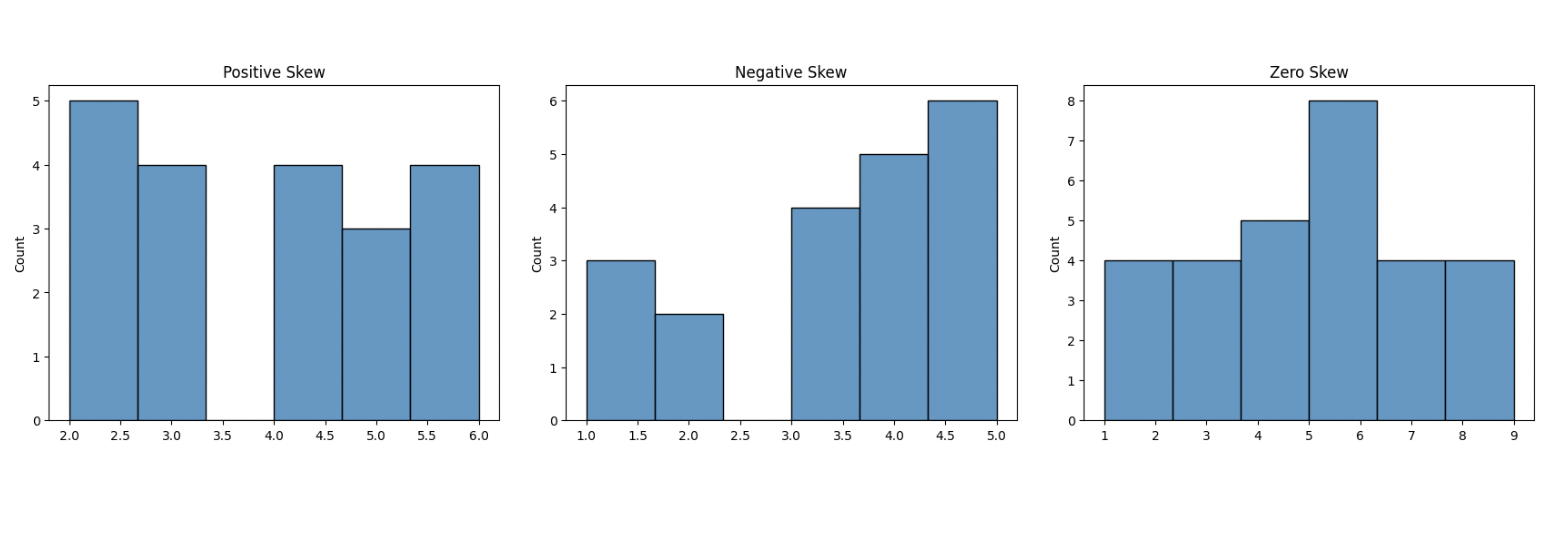

Positive Skew = Mean > Median and Mode
Negative Skew = Mean < Median and Mode

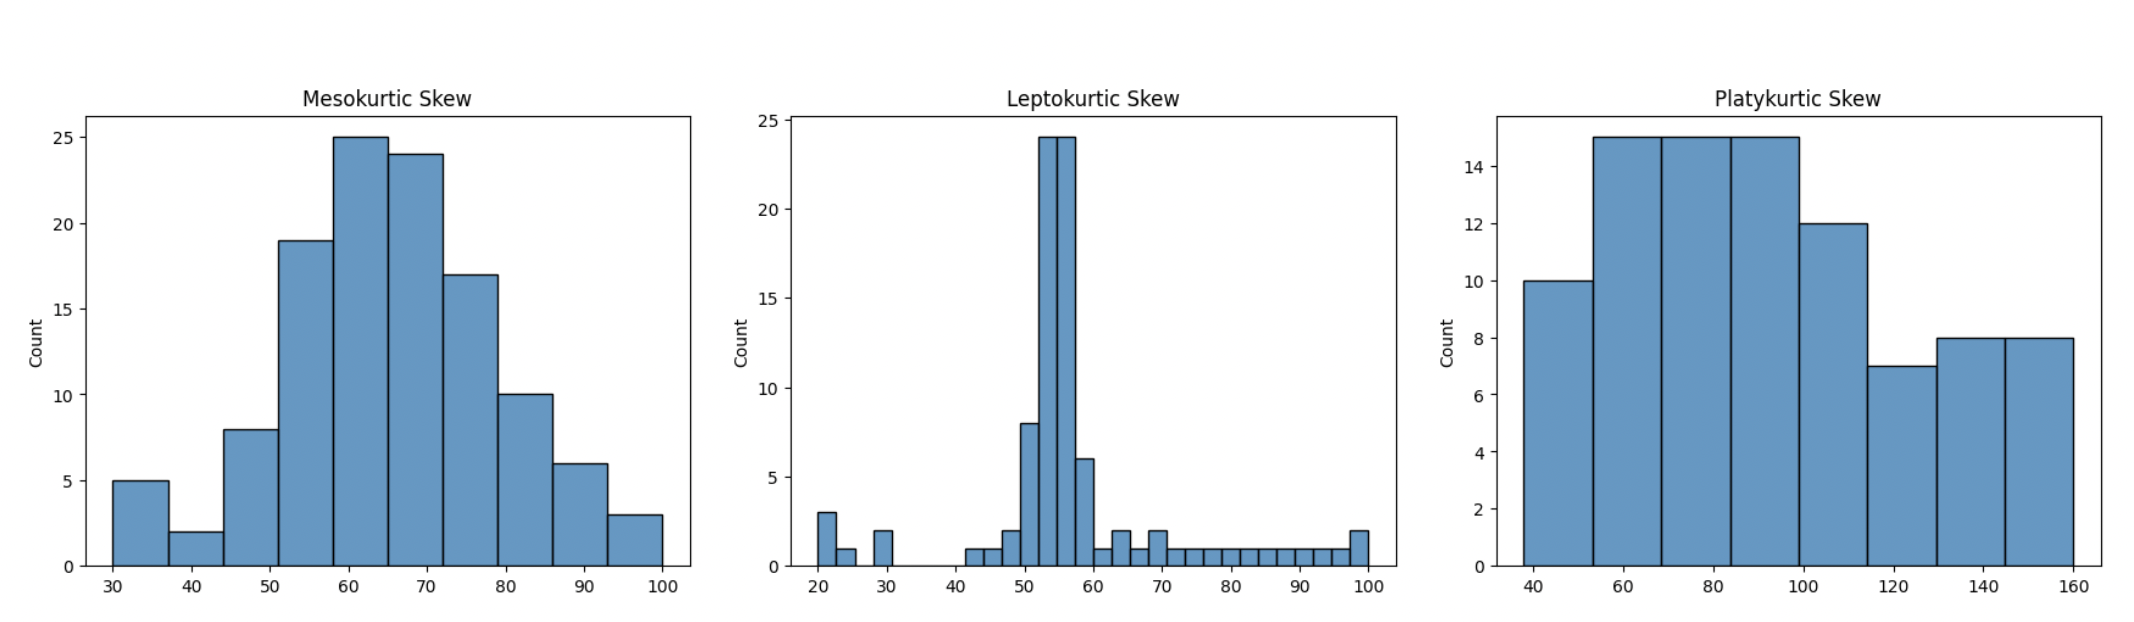

We see this on histograms:
- Normal Distribution (aka Mesokurtic Skew) = Perfect normal distribution would have a skew=0 = Thinner tails mean less volatility
- Leptokurtic = High mean with more extreme values on each side 
- Platykurtic = Uniform, Wide and Flat = can have a right skew or a left skew

## Outliers

### For Numerical columns, we can check Boxplots. However, a more elegant solution is to use Z-score.

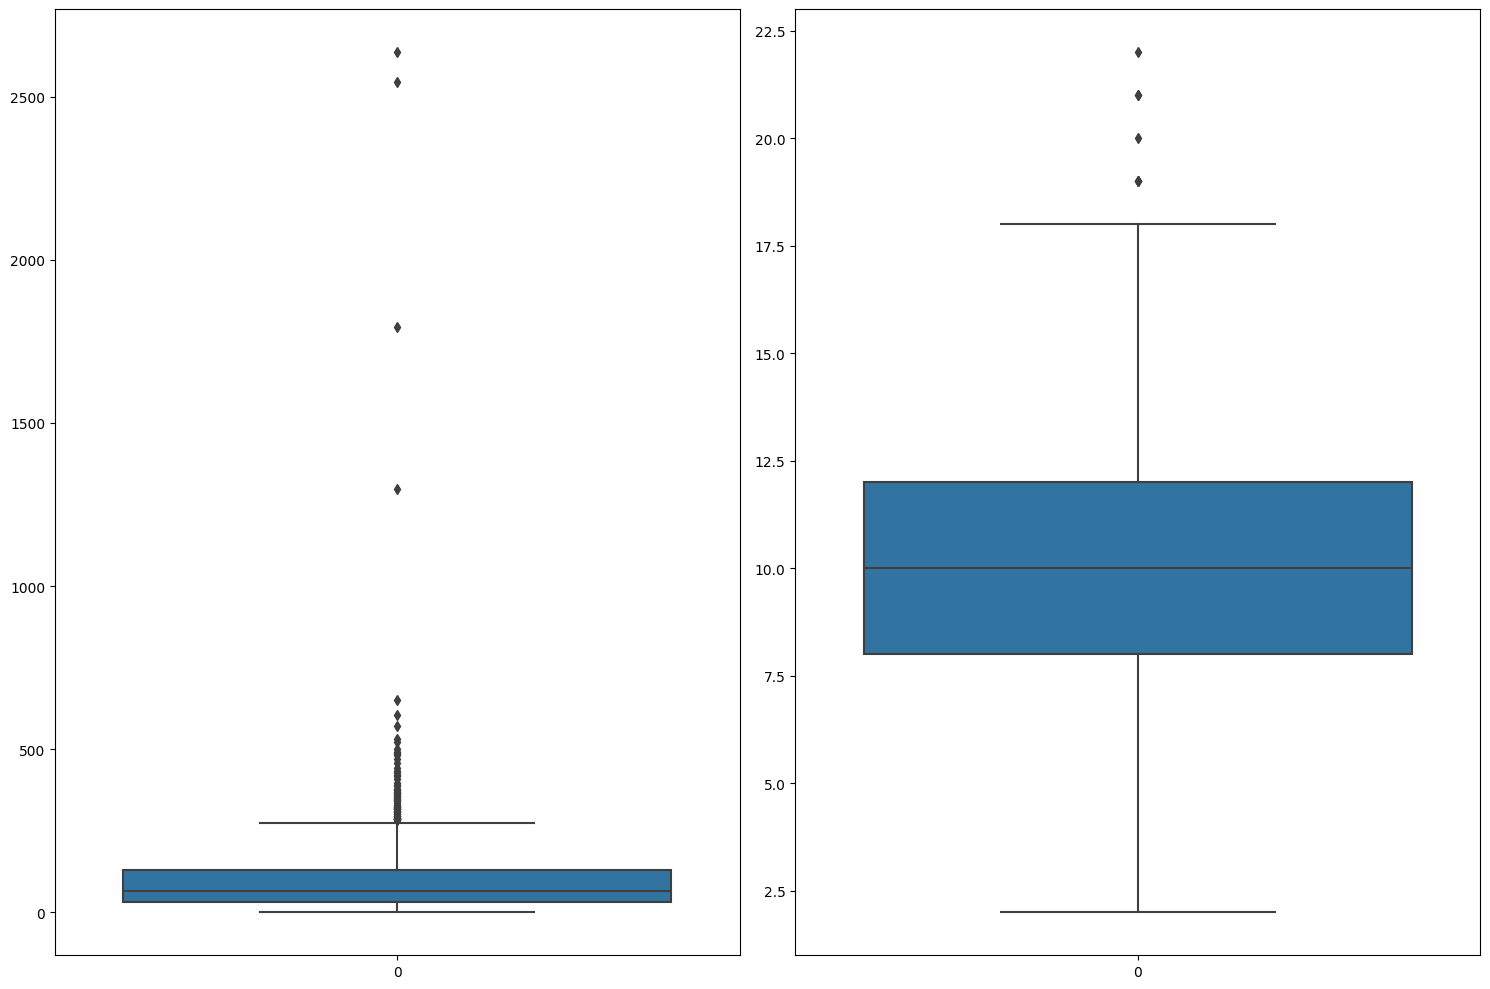

In [45]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (15,10))
plt1 = sns.boxplot(df['Price'], ax = ax1)
plt2 = sns.boxplot(df['Units Sold'], ax = ax2)
plt.tight_layout()

In [46]:
numerical_columns = ['Price','Units Sold']

In [47]:
for column in numerical_columns:
    skewness_values = []
    s = skew(df[column])
    k = kurtosis(df[column])
    print(f'{column}: skewness = {s}, kurtosis = {k}')

Price: skewness = 9.226415853013966, kurtosis = 126.803588540368
Units Sold: skewness = 0.2931451966107103, kurtosis = 0.19664945113243926


In [48]:
#based on skewness and kurtosis, we use z score to remove outliers

if abs(s) > 1:
    df[column] = df[column].apply(lambda x: np.log(x + 1))


In [49]:
z_scores = zscore(df[numerical_columns])

In [50]:
threshold = 3

In [51]:
df = df[(np.abs(z_scores) < threshold).all(axis=1)]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1028 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product     1028 non-null   object        
 1   Region      1028 non-null   object        
 2   Price       1028 non-null   float64       
 3   Units Sold  1028 non-null   float64       
 4   Sale Date   1028 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 48.2+ KB


In [53]:
# Check Skew and Kurtosis after removing outliers
for column in numerical_columns:
    skewness_values = []
    s = skew(df[column])
    k = kurtosis(df[column])
    print(f'{column}: skewness = {s}, kurtosis = {k}')

Price: skewness = 1.8365632172598076, kurtosis = 3.740910279855174
Units Sold: skewness = 0.17795221827169003, kurtosis = -0.1208190028999967


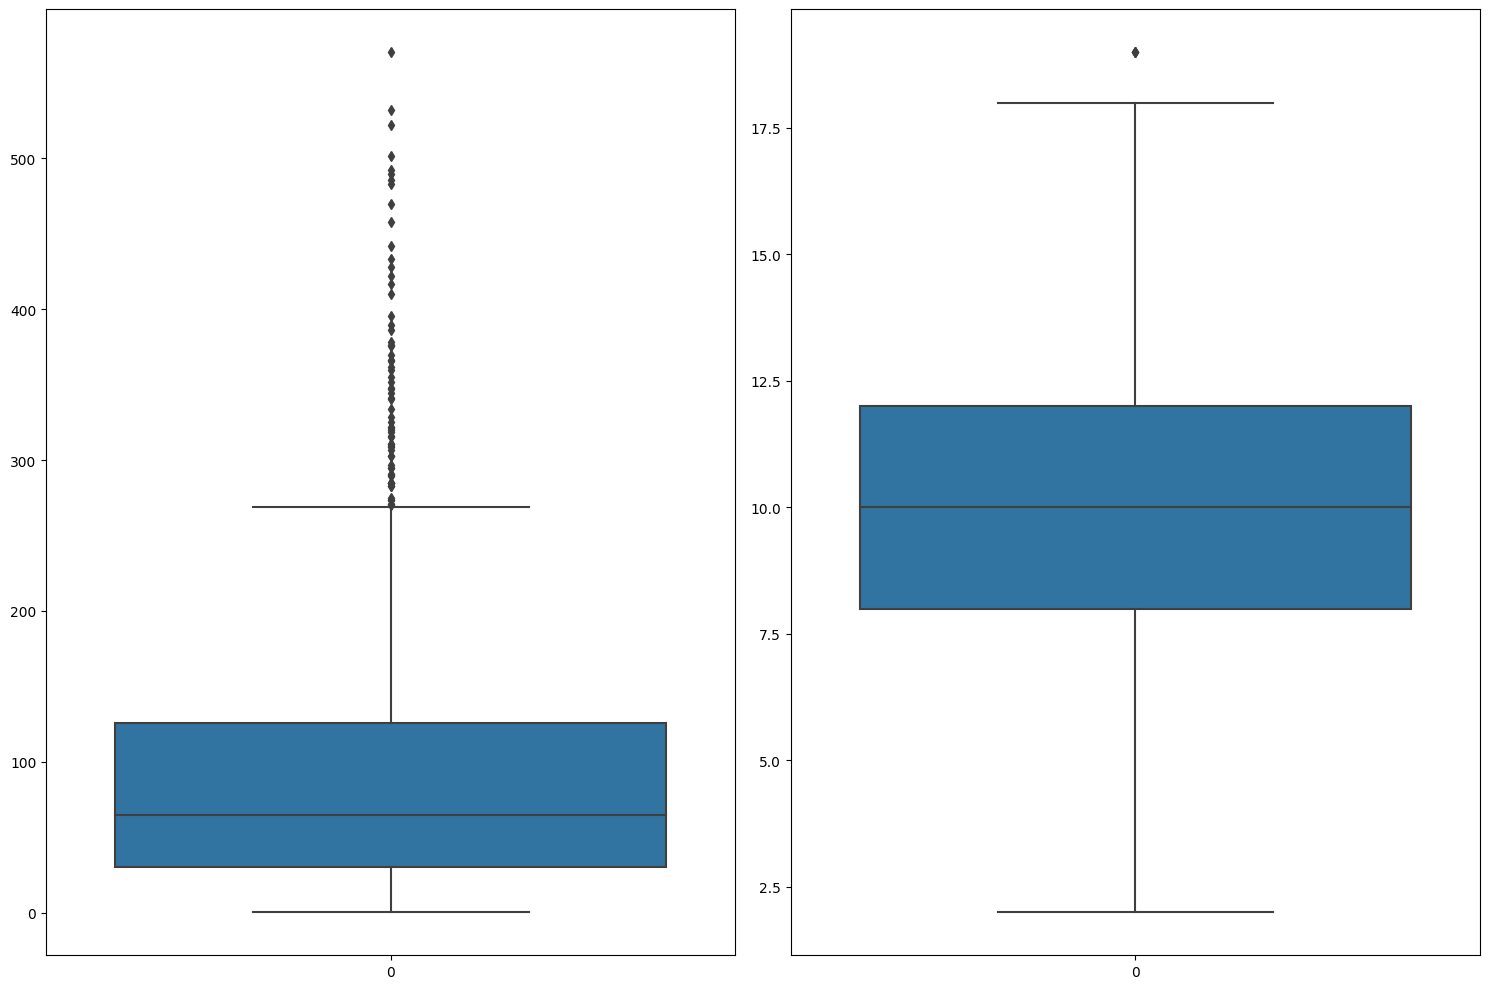

In [54]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (15,10))
plt1 = sns.boxplot(df['Price'], ax = ax1)
plt2 = sns.boxplot(df['Units Sold'], ax = ax2)
plt.tight_layout()

See the improvement?

## EDA 
Descriptive stats and visualization

### For Numerical columns, we use Histplot

<Axes: xlabel='Price', ylabel='Count'>

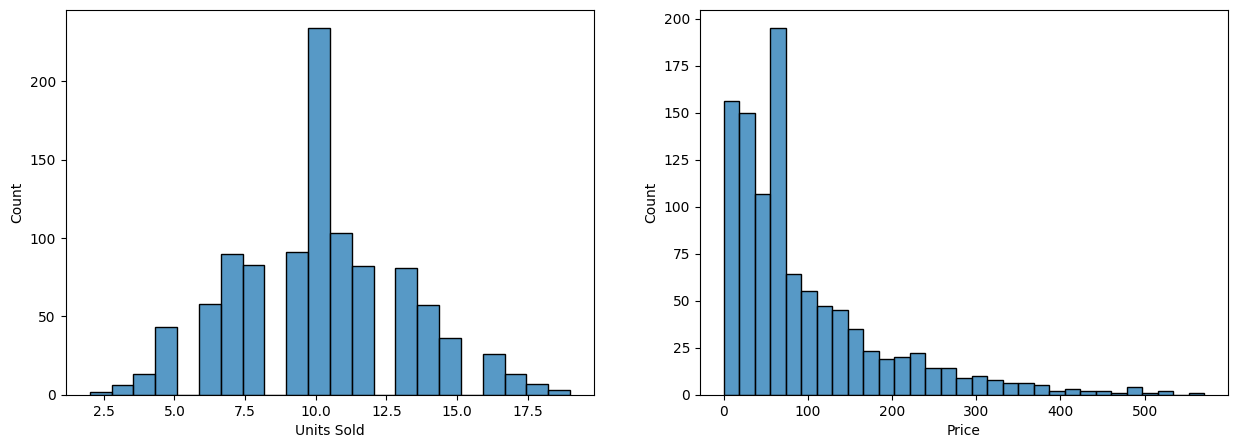

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df['Units Sold'], ax=ax1)
sns.histplot(df['Price'], ax=ax2)

We can see Price has a Right Skew = This means that most products are sold at a low price but a few are sold at a high price (We printed skew and kurtosis above to validate what we're seeing) - Skew for price is 1.86 indicating a right skew. 

Units Sold is normally distributed = Most products selling 10 units per transaction. Skew for units sold is 0.177 (so close to 0) = validates our normal distribution. 

Since we see a normal distribution, Kurtosis = -0.12 which indicates thin tails (less volatility). 

### For Categorical Variables, lets start by looking at counts distribution

<Axes: xlabel='Product'>

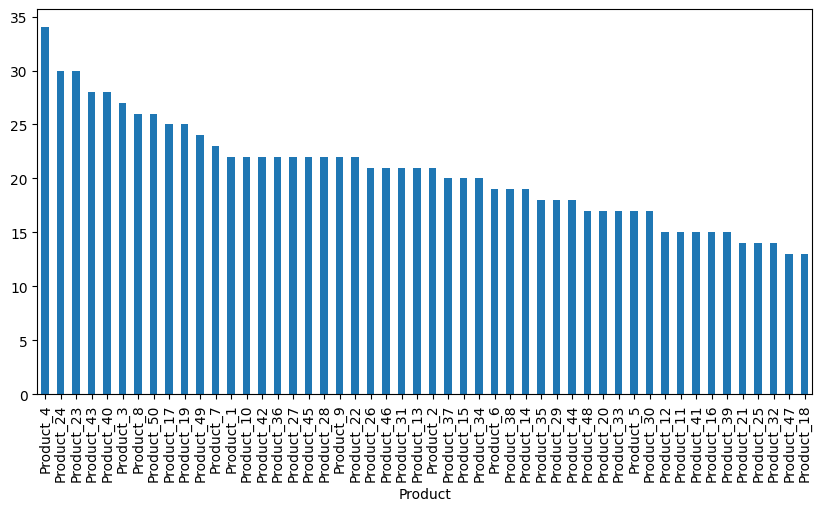

In [56]:
df.groupby('Product')['Units Sold'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

We can see which product has been sold the most and which one is the least sold. 

<Axes: xlabel='Region'>

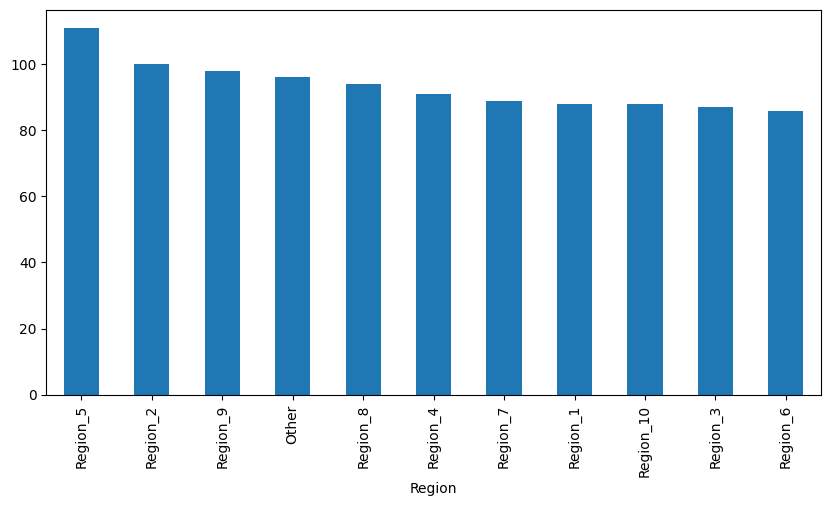

In [57]:
df.groupby('Region')['Units Sold'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

Similarly for Region

### BiVariate Analysis
Lets look at some descriptive stats for both numerical columns against the categorical columns

In [58]:
units_by_region = df.groupby('Region')['Units Sold'].aggregate(['sum','mean','median','count'])
units_by_region

sum       mean  median  count
Region                                     
Other       954.0   9.937500    10.0     96
Region_1    885.0  10.056818    10.0     88
Region_10   869.0   9.875000    10.0     88
Region_2   1034.0  10.340000    10.0    100
Region_3    855.0   9.827586    10.0     87
Region_4    928.0  10.197802    10.0     91
Region_5   1099.0   9.900901    10.0    111
Region_6    888.0  10.325581    10.0     86
Region_7    956.0  10.741573    10.0     89
Region_8    980.0  10.425532    10.0     94
Region_9    970.0   9.897959    10.0     98

In [60]:
units_by_product = df.groupby('Product')['Units Sold'].aggregate(['sum','mean','median','count'])
units_by_product

sum       mean  median  count
Product                                    
Product_1   224.0  10.181818    10.0     22
Product_10  245.0  11.136364    11.0     22
Product_11  165.0  11.000000    11.0     15
Product_12  145.0   9.666667    10.0     15
Product_13  218.0  10.380952    10.0     21
Product_14  209.0  11.000000    10.0     19
Product_15  215.0  10.750000    10.0     20
Product_16  161.0  10.733333    11.0     15
Product_17  245.0   9.800000    10.0     25
Product_18  155.0  11.923077    12.0     13
Product_19  256.0  10.240000    11.0     25
Product_2   220.0  10.476190    10.0     21
Product_20  152.0   8.941176     9.0     17
Product_21  139.0   9.928571     9.5     14
Product_22  218.0   9.909091    10.0     22
Product_23  293.0   9.766667    10.0     30
Product_24  315.0  10.500000    10.0     30
Product_25  134.0   9.571429     9.5     14
Product_26  207.0   9.857143    10.0     21
Product_27  198.0   9.000000     9.0     22
Product_28  237.0  10.772727    11.0     22
Product_29  188.0  10.444444    10.5     18
Product_3   265.0   9.814815    10.0     27
Product_30  152.0   8.941176     9.0     17
Product_31  193.0   9.190476    10.0     21
Product_32  162.0  11.571429    12.0     14
Product_33  158.0   9.294118     9.0     17
Product_34  198.0   9.900000     9.5     20
Product_35  191.0  10.611111    10.0     18
Product_36  200.0   9.090909    10.0     22
Product_37  198.0   9.900000    10.0     20
Product_38  206.0  10.842105    10.0     19
Product_39  132.0   8.800000     8.0     15
Product_4   322.0   9.470588    10.0     34
Product_40  317.0  11.321429    11.0     28
Product_41  167.0  11.133333    11.0     15
Product_42  237.0  10.772727    10.0     22
Product_43  274.0   9.785714    10.0     28
Product_44  190.0  10.555556    10.0     18
Product_45  227.0  10.318182    11.0     22
Product_46  213.0  10.142857    10.0     21
Product_47  124.0   9.538462    10.0     13
Product_48  171.0  10.058824    10.0     17
Product_49  245.0  10.208333    10.0     24
Product_5   175.0  10.294118    10.0     17
Product_50  250.0   9.615385     9.0     26
Product_6   186.0   9.789474    10.0     19
Product_7   233.0  10.130435    10.0     23
Product_8   275.0  10.576923    10.5     26
Product_9   218.0   9.909091    10.0     22

<Axes: xlabel='Product'>

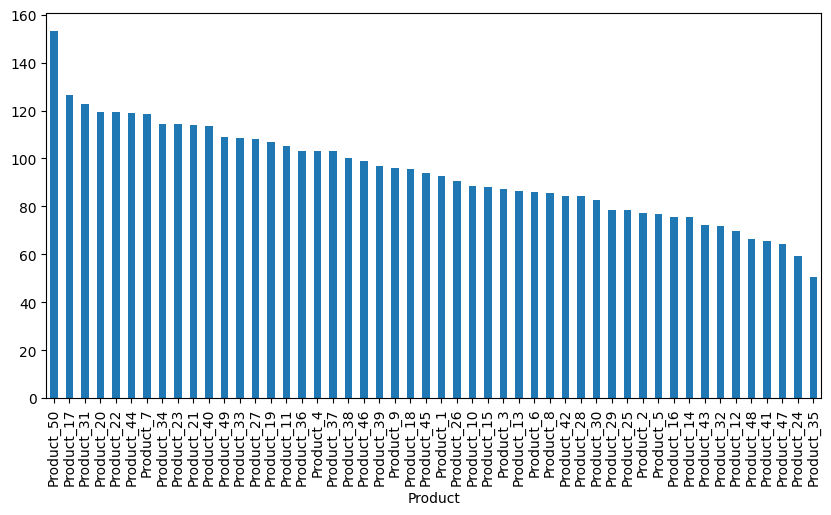

In [61]:
# Lets look at the avg price per product
df.groupby('Product')['Price'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))


We can see that Product 50 has the highest price; Product 39, while it sells the least, does not have the lowest price. The price on average is somewhere in the middle. 

We could also look at Scatterplots and Bubble charts for all combinations of bivariate analysis. 

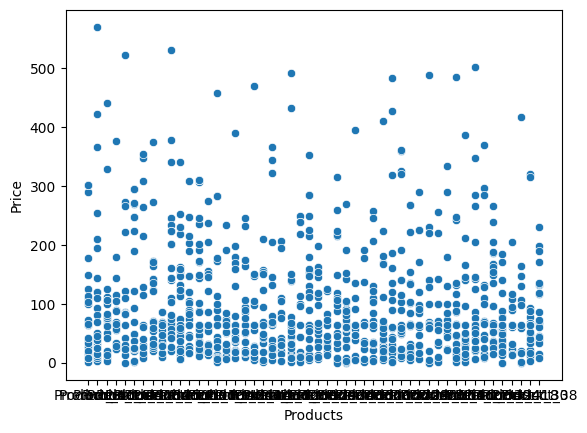

In [62]:
sns.scatterplot(data=df, x='Product', y='Price')
plt.xlabel('Products')
plt.ylabel('Price')
plt.show()


Now let's compare price and units.

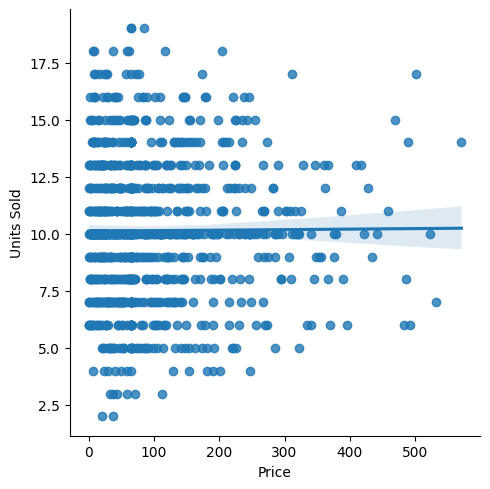

In [63]:
sns.lmplot(data = df, x='Price', y='Units Sold')

Relationship is pretty flat = Units sold is not dependent on price

### Multivariate Analysis

In [64]:
df['Revenue'] = df['Price'] * df['Units Sold']

Lets look at each region with Products, Avg Price and Avg and Total Revenue and Units Sold. 

In [65]:
region_1 = df[df['Region']=='Region_1'].groupby('Product').aggregate({'Price':'mean','Units Sold':['sum','mean'],'Revenue':['sum','mean']})

<Axes: xlabel='Product'>

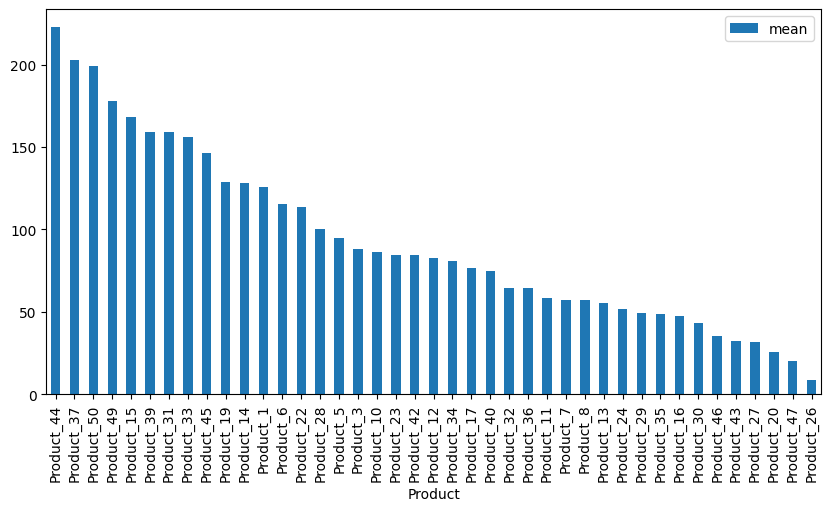

In [66]:
region_1['Price'].sort_values('mean',ascending=False).plot(kind='bar', figsize=(10,5))


<Axes: xlabel='Product'>

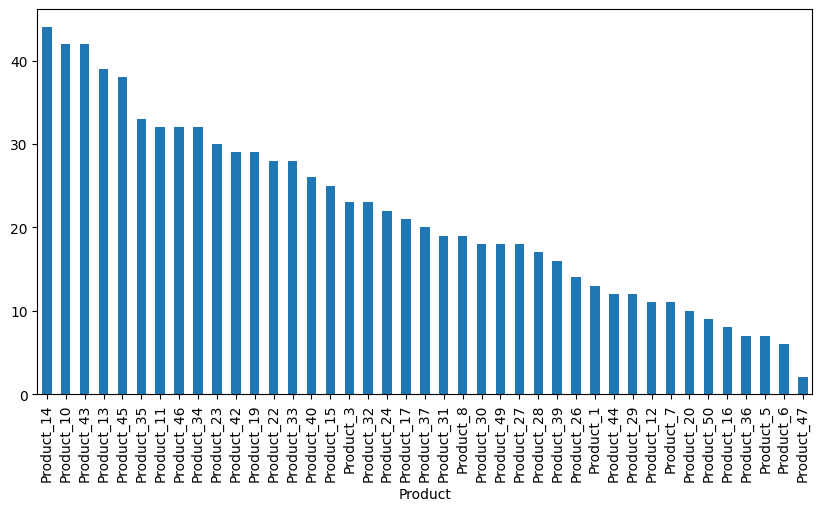

In [67]:
region_1['Units Sold']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<Axes: xlabel='Product'>

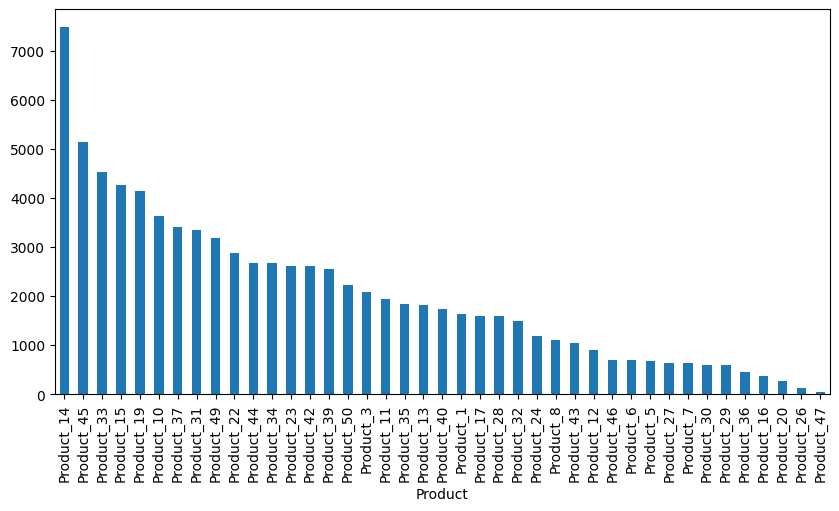

In [68]:
region_1['Revenue']['sum'].sort_values(ascending=False).plot(kind='bar', figsize=(10,5))


- Product 14 yields the highest revenue, with the highest number of units sold
- Product 37 is the most expensive, and yields the 6th highest revenue
- Product 47 offers the least revenue, the least units sold, and has a low price
- Product 26 has the lowest price and second lowest revenue

Generally, we could recommend that Region 1 should stop selling Products 47 and 26. It should try to upsell Product 37 to increase profitability.

You can do this for each Region - depending on as deep as you want to go. 

Could also do this for Products instead of regions. 

Correlation matrix for numerical columns:

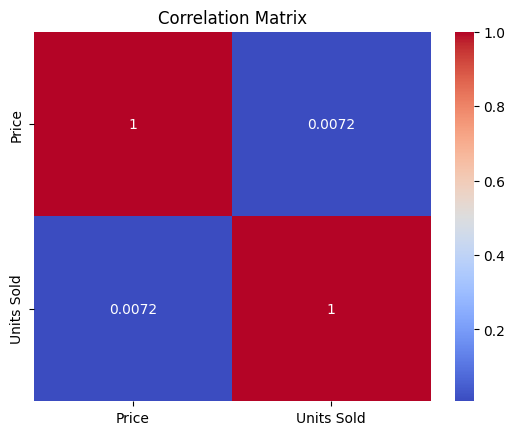

In [69]:
corr_matrix = df[numerical_columns].corr()
# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Hypothesis Testing
P-Value: The probability, under the assumption that the null hypothesis (H0) is true, of obtaining a result equal to or more extreme than what was actually observed.
A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.


Cautions: P-values alone are not enough to make a definitive conclusion. The p-value does not tell us the size of an effect, the importance of a result, or the probability that the null hypothesis is true.


In [71]:
import seaborn as sns

In [73]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [74]:
iris = sns.load_dataset('iris')

In [75]:
iris

sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

In [76]:
setosa_sepal_length = iris[iris['species']=='setosa']['sepal_length']
known_mean = 5.0

### 1. Parametric Tests: 
Assume normal distribution, groups have homogeneity of variance, data is measures on an interval or ratio scale

1.1. T-test: 

1.1.1. One sample: Tests if the mean of a single group differs from a specified value

In [77]:
# Use this when comparing sample data against a standard (H0 mean)

# Here we are checking if the setosa species sepal length is equal to a specific know mean 
# H0: Setosa Mean Sepal Length is 5.0
t_stat, p_value = stats.ttest_1samp(setosa_sepal_length,known_mean)

In [78]:
# Bigger value = rejects null hypothesis and vice versa
t_stat

0.12036212238318053

In [79]:
# Bigger value = accepts null hypothesis = so here we accept it
p_value

0.9046884777690936

1.1.2. Independent two sample: Tests if the means of two independent groups are different.

In [80]:
# lets compare the mean sepal width of 2 species
# H0: Both species have similar mean sepal width
versicolor_sepal_length = iris[iris['species'] == 'versicolor']['sepal_width']
virginica_sepal_length = iris[iris['species'] == 'virginica']['sepal_width']

t_stat, p_value = stats.ttest_ind(versicolor_sepal_length, virginica_sepal_length)

# Positive t_stat indicates versicolor has a larger mean sepal width, negative t_stat indicates virginica has larger mean
# High p_value = accept H0 = there is no significant difference b/w mean sepal length of the 2
# very low p-value indicates that there is a significant difference
print(f"Two-Sample T-Test: t = {t_stat}, p = {p_value}")

Two-Sample T-Test: t = -3.2057607502218186, p = 0.0018191004238894803


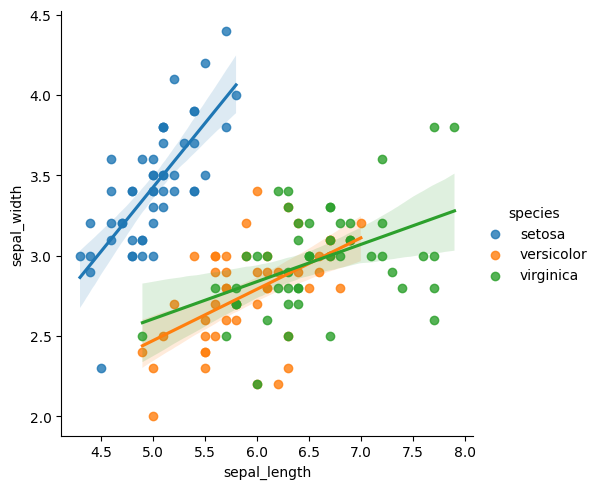

In [260]:
sns.lmplot(data = iris, x='sepal_length', y='sepal_width', hue = 'species')


1.1.3. Paired: Tests if the means of 2 related groups are different (Used in before and after scenarios). 

In [81]:
#Since there's no before - after pair, hypothetical scenario: compare sepal length and width of setosa (as if they are before and after values)
setosa_sepal_width = iris[iris['species'] == 'setosa']['sepal_width']

t_stat, p_value = stats.ttest_rel(setosa_sepal_length, setosa_sepal_width)

# + T_stat = sepal length > sepal width, - T_stat suggests opposite
# High P_value = accept H0 = there is no significant difference between the 2
print(f"Paired T-Test: t = {t_stat}, p = {p_value}")

Paired T-Test: t = 42.32339235217487, p = 3.0231710793686155e-40


1.2. Chi-squared Test: Determine  whether there is a significant association between 2 categorical variables in a sample. 

In [82]:
# Convert 'sepal_width' to a categorical variable
iris['sepal_width_cat'] = pd.cut(iris['sepal_width'], bins=[0, 3, 3.5, 4])

# Create a contingency table
contingency_table = pd.crosstab(iris['species'], iris['sepal_width_cat'])

chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# We see a statistical significance between species and sepal width bins
print(f"Chi-squared: {chi2}")
print(f"P-value: {p_val}")

Chi-squared: 51.132288195334525
P-value: 2.0945619933052866e-10


1.3. ANOVA Test: Tests if the means of 3 or more independent groups are different. 

In [83]:
# ANOVA TO see if there is a diff b/w the means of all 3 groups
setosa = iris[iris['species'] == 'setosa']['sepal_width']
versicolor = iris[iris['species'] == 'versicolor']['sepal_width']
virginica = iris[iris['species'] == 'virginica']['sepal_width']

f_stat, p_val = stats.f_oneway(setosa, versicolor, virginica)

# High F_stat indicates that the means of the three species are significantly different from one another.
# P-val soooo low = reject H0 = all groups are not the same 
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

F-statistic: 49.160040089612075
P-value: 4.492017133309115e-17


1.4. Correlation Tests:

1.4.1. Pearson's correlation: Tests for a linear relationship between two continuous variables.

In [84]:
pearson_corr, p_val = stats.pearsonr(iris['sepal_length'], iris['sepal_width'])

print(f"Pearson's correlation: {pearson_corr}")
print(f"P-value: {p_val}")

Pearson's correlation: -0.11756978413300195
P-value: 0.15189826071144857


In [85]:
pearson_corr, p_val = stats.pearsonr(iris[iris['species']=='setosa']['sepal_length'], iris[iris['species']=='setosa']['sepal_width'])

print(f"Pearson's correlation: {pearson_corr}")
print(f"P-value: {p_val}")

Pearson's correlation: 0.7425466856651598
P-value: 6.709843017660548e-10


In [86]:
# The null hypothesis for a linear relatinship is that there is NO linear relationship. 
# We can see in this case that the correlation is a low value, and the p-value indicates an insignificant relationship.

iris.corr(numeric_only=True)

sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.117570      0.871754     0.817941
sepal_width      -0.117570     1.000000     -0.428440    -0.366126
petal_length      0.871754    -0.428440      1.000000     0.962865
petal_width       0.817941    -0.366126      0.962865     1.000000

1.4.2. Spearman's correlation: Tests for a monotonic
relationship (either increasing or decreasing, but not
necessarily linear) between two continuous variables.

In [87]:
# Select numerical columns
numerical_iris = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

# Compute the Spearman's correlation matrix
corr_matrix, p_values = stats.spearmanr(numerical_iris)

# Print the correlation matrix
print("Spearman's correlation matrix:")
print(corr_matrix)

# Optionally, print the p-values
print("\nP-values:")
print(p_values)

Spearman's correlation matrix:
[[ 1.         -0.16677766  0.88189813  0.83428878]
 [-0.16677766  1.         -0.30963509 -0.28903175]
 [ 0.88189813 -0.30963509  1.          0.93766682]
 [ 0.83428878 -0.28903175  0.93766682  1.        ]]

P-values:
[[0.00000000e+00 4.13679942e-02 3.44308728e-50 4.18944668e-40]
 [4.13679942e-02 0.00000000e+00 1.15393838e-04 3.34298106e-04]
 [3.44308728e-50 1.15393838e-04 0.00000000e+00 8.15659685e-70]
 [4.18944668e-40 3.34298106e-04 8.15659685e-70 0.00000000e+00]]


### 2. Non-parametric Tests
No assumptions, more robust when dealing with non-normally distributed data
However, parametric tests are more reliable

2.1. Mann-Whitney U Test: checks if there is a significant difference between the distribution of two independent variables

In [268]:
setosa = iris[iris['species'] == 'setosa']['sepal_width']
versicolor = iris[iris['species'] == 'versicolor']['sepal_width']

U_stat, p_val = stats.mannwhitneyu(setosa, versicolor)

print(f"U-statistic: {U_stat}")
print(f"P-value: {p_val}")

U-statistic: 2312.0
P-value: 2.1433797280775203e-13


2.2. Kruskal-Wallis H Test: used to compare two or more groups; it’s an extension of the Mann-Whitney U test and a non-parametric comparable to ANOVA

In [269]:
setosa = iris[iris['species'] == 'setosa']['sepal_width']
versicolor = iris[iris['species'] == 'versicolor']['sepal_width']
virginica = iris[iris['species'] == 'virginica']['sepal_width']

H, pval = stats.kruskal(setosa, versicolor, virginica)

print('The test statistic:', H)
print('The p-value of the test:', pval)

The test statistic: 63.571146104163795
The p-value of the test: 1.5692820940316782e-14


2.3. Spearman's Rank Correlation: measures whether 2 variables increase or decrease at a constant rate (value b/w -1 and 1 = closer to 1 indicates strong positive correlation, -1 indicates inverse correlation, 0 indicates no correlation)

In [270]:
spearman_corr = numerical_iris.corr(method='spearman')

# Print the Spearman's correlation matrix
print("Spearman's rank correlation matrix:")
print(spearman_corr)

Spearman's rank correlation matrix:
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.166778      0.881898     0.834289
sepal_width      -0.166778     1.000000     -0.309635    -0.289032
petal_length      0.881898    -0.309635      1.000000     0.937667
petal_width       0.834289    -0.289032      0.937667     1.000000


### Lets come back to our sales data and do some statistical testing
ANOVA Test to see if price and Units Sold changes with each region 

In [88]:
r1 = df[df['Region'] == 'Region_1']['Price']
r2 = df[df['Region'] == 'Region_2']['Price']
r3 = df[df['Region'] == 'Region_3']['Price']
r4 = df[df['Region'] == 'Region_4']['Price']
r5 = df[df['Region'] == 'Region_5']['Price']
r6 = df[df['Region'] == 'Region_6']['Price']
r7 = df[df['Region'] == 'Region_7']['Price']
r8 = df[df['Region'] == 'Region_8']['Price']
r9 = df[df['Region'] == 'Region_9']['Price']
r10 = df[df['Region'] == 'Region_10']['Price']
rother = df[df['Region'] == 'Other']['Price']

p_val = stats.f_oneway(r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,rother)
print(p_val)

F_onewayResult(statistic=0.8429922911146521, pvalue=0.5870922954505772)


However, considering Price is not normally distributed, lets do a non-parametric ANOVA i.e. Kruskal Wallis

In [89]:
H, pval = stats.kruskal(r1,r2,r3,r4,r5,r6,r7,r8,r9, r10, rother)

print('The test statistic:', H)
print('The p-value of the test:', pval)

The test statistic: 9.650854898218391
The p-value of the test: 0.47164010452095284


We got high p-values indicating no statistically significant difference between them - this means we can comfortably assign all regions to any experiment we design.

Could do the same thing for Units Sold. 

## Experiment Design

Lets say our objective is to see the impact of price on units sold across different regions for a specific product - Product_50. 

H0: Changing the price of Product_50 does not have a significant effect on units sold

Ha: Changing the price of Product_50 has a significant effect on the units sold.

In [90]:
# Filter data for the selected product
product_data = df[df['Product'] == 'Product_50']

# Split data into control and treatment groups based on region
control_group = product_data[product_data['Region'] == 'Region_1']
treatment_group = product_data[product_data['Region'] == 'Region_2']

In [91]:
t_stat, p_val = stats.ttest_ind(control_group['Units Sold'], treatment_group['Units Sold'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: -2.7229437449320923
P-value: 0.041628655373345126


Low P-value = indicates that there is a statistically significant difference in the units sold between the 2 regions

This result would suggest that the pricing strategy implemented in the treatment group has a significant effect on the units sold.

## Feature Engineering
Some examples:

• Categorizing continuous data (e.g., age range instead of age)

• Extracting elements from existing data points (e.g., hour from a datetime variable)

• Scaling / standardizing data (e.g., setting to a range of 0-1)

• Inferring new data points

• Representations


In [92]:
# For example
df['Revenue'] = df['Price'] * df['Units Sold']

# PCA - Type of FE
Dimensionality Reduction: when we have too many features in a dataset, this can slow down our models a lot! If a
model has a lot of data to process, the more features, the longer it will take
• Dimensionality reduction is a technique we can use to mathematically reduce the dimensions – in
other words, the number of variables – in a data set, in order to simplify the data set
• PCA aims to transform the features in a dataset into a new set of features, called principal
components, which are uncorrelated and capture the maximum possible information (in terms of
variance) from the data
• For example, if we had an original data set with 16 columns, we could reduce the columns to 2 in order
to have less data for a model to work with


Assumptions: 

• PCA assumes correlation between features
• It is sensitive to outliers
• It assumes a linear relationship between features – not well suited for non-linear relationships
• Assumes no missing values


In [93]:
df2 = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/module_5_feature_engineering_demo.csv')

In [94]:
df2.drop('Unnamed: 0', axis=1, inplace=True)

In [95]:
df2.head()

Height     Weight  Calories_Intake  Exercise_Time        BMI  Age   
0  187.640523  81.119254      1733.539473       4.593274  23.039374   70  \
1  174.001572  87.849478      1644.014918       3.568722  29.015686   38   
2  179.787380  61.553704      2523.067529       2.885513  19.043018   76   
3  192.408932  72.094281      2020.812760       3.251630  19.473784   35   
4  188.675580  74.561067      2459.594194       1.789144  20.945017   49   

   Resting_Heart_Rate  
0           54.540176  
1           63.510746  
2           49.502603  
3           72.310220  
4           67.864721

In [96]:
# Standardize the features
scaler = StandardScaler()
df_std = scaler.fit_transform(df2)

# Perform PCA
pca = PCA()
df_pca = pca.fit_transform(df_std)

# The transformed data is an array, convert it back into a dataframe
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(len(df2.columns))])

# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the cumulative explained variance ratio
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', cumsum_variance)

# Show the first few rows of transformed dataframe
df_pca.head()

Explained variance ratio: [0.28857346 0.18072185 0.14675488 0.14381463 0.13558216 0.10353415
 0.00101888]
Cumulative explained variance ratio: [0.28857346 0.46929531 0.61605019 0.75986482 0.89544697 0.99898112
 1.        ]


PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -0.395268 -1.182948  1.791319  2.336967  0.037477  0.366259 -0.018202
1  0.819082 -0.205962  2.084828  0.028116 -0.058311  0.446441 -0.061576
2 -1.171866 -0.469183 -0.324207  1.639464 -0.240676 -0.935364  0.040073
3 -1.106793  0.798769  2.060352  0.535101  1.421538  0.537776  0.082936
4 -0.772500  1.500282  0.797973  0.753864  1.115887 -0.730499  0.036682

In [106]:
# Let's do the same, but now let's reduce to 2 components
# Perform PCA
pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_std)

# The transformed data is an array, convert it back into a dataframe
df_pca = pd.DataFrame(df_pca)

# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the cumulative explained variance ratio
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', cumsum_variance)

# Show the first few rows of transformed dataframe
df_pca.head()

Explained variance ratio: [0.28857346 0.18072185]
Cumulative explained variance ratio: [0.28857346 0.46929531]


0         1
0 -0.395268 -1.182948
1  0.819082 -0.205962
2 -1.171866 -0.469183
3 -1.106793  0.798769
4 -0.772500  1.500282

We can see that with 2 componentts, only 46% of the varability in data is explained

### More Feature Engineering

In [108]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'])

In [107]:
df['month'] = df['Sale Date'].dt.month

In [109]:
df['day'] = df['Sale Date'].dt.day

In [110]:
df.head()

Product    Region   Price  Units Sold  Sale Date  Revenue  month  day
0   Product_3  Region_1   72.87        10.0 2022-01-01   728.70      1    1
1  Product_40  Region_2   46.19        10.0 2022-01-02   461.90      1    2
2   Product_1  Region_5   64.62         4.0 2022-01-03   258.48      1    3
3   Product_6  Region_8  143.47         8.0 2022-01-04  1147.76      1    4
4  Product_44  Region_4  122.54        10.0 2022-01-05  1225.40      1    5

In [111]:
df['Units Sold'].value_counts().sort_values()

Units Sold
2.0       2
19.0      3
3.0       6
18.0      7
17.0     13
4.0      13
16.0     26
15.0     36
5.0      43
14.0     57
6.0      58
13.0     81
12.0     82
8.0      83
7.0      90
9.0      91
11.0    103
10.0    234
Name: count, dtype: int64

In [112]:
# Create function to classify units sold
def total_cat(x):
    if x >= 0 and x < 5:
        return '0-5'
    elif x >= 5 and x < 10:
        return '5-10'
    elif x >= 10 and x < 15:
        return '10-15'
    else:
        return '15+'

In [113]:
df['units_bin'] = df['Units Sold'].apply(total_cat)

In [114]:
df

Product    Region   Price  Units Sold  Sale Date  Revenue  month   
0      Product_3  Region_1   72.87        10.0 2022-01-01   728.70      1  \
1     Product_40  Region_2   46.19        10.0 2022-01-02   461.90      1   
2      Product_1  Region_5   64.62         4.0 2022-01-03   258.48      1   
3      Product_6  Region_8  143.47         8.0 2022-01-04  1147.76      1   
4     Product_44  Region_4  122.54        10.0 2022-01-05  1225.40      1   
...          ...       ...     ...         ...        ...      ...    ...   
1045  Product_42  Region_3   18.63         9.0 2023-07-10   167.67      7   
1046   Product_4  Region_3  159.27        10.0 2024-07-14  1592.70      7   
1047  Product_43  Region_1    2.91        13.0 2023-08-17    37.83      8   
1048  Product_27  Region_7    1.96         8.0 2024-03-10    15.68      3   
1049   Product_3     Other  302.68        11.0 2023-09-09  3329.48      9   

      day units_bin  
0       1     10-15  
1       2     10-15  
2       3       0-5  
3       4      5-10  
4       5     10-15  
...   ...       ...  
1045   10      5-10  
1046   14     10-15  
1047   17     10-15  
1048   10      5-10  
1049    9     10-15  

[1028 rows x 9 columns]

Some more ideas for this dataset: 

- Price bins: Low, medium, high


<a id='dummy_var'></a>
## FE: Dummy Variables 
1. Mapping categorical columns in the form of numbers to words for better interpretability

In [115]:
month_mapping = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
df['month'] = df['month'].map(month_mapping)

2. Create dummy columns

In [116]:
month_dummies = pd.get_dummies(df['month'])

In [117]:
df = pd.concat([df,month_dummies],axis=1)

In [118]:
df.head()

Product    Region   Price  Units Sold  Sale Date  Revenue    month  day   
0   Product_3  Region_1   72.87        10.0 2022-01-01   728.70  January    1  \
1  Product_40  Region_2   46.19        10.0 2022-01-02   461.90  January    2   
2   Product_1  Region_5   64.62         4.0 2022-01-03   258.48  January    3   
3   Product_6  Region_8  143.47         8.0 2022-01-04  1147.76  January    4   
4  Product_44  Region_4  122.54        10.0 2022-01-05  1225.40  January    5   

  units_bin  April  ...  December  February  January   July   June  March   
0     10-15  False  ...     False     False     True  False  False  False  \
1     10-15  False  ...     False     False     True  False  False  False   
2       0-5  False  ...     False     False     True  False  False  False   
3      5-10  False  ...     False     False     True  False  False  False   
4     10-15  False  ...     False     False     True  False  False  False   

     May  November  October  September  
0  False     False    False      False  
1  False     False    False      False  
2  False     False    False      False  
3  False     False    False      False  
4  False     False    False      False  

[5 rows x 21 columns]

# Machine Learning Models

## Model Pipelines
![Data Pre-processing (1).png](<attachment:Data Pre-processing (1).png>)

We already covered Data Cleaning, and some transformations so lets dive into everything else on this map - Step by step. 

### 📨 X = Predictors = Independent Variables = Input

### 🔮 Y = Target = Dependent Variable = Output 

Why? Because Y = MX + C where M = Slope/Coefficient and C = Intercept

### Step 0: Identify target variable and determine which models will be applied. 
If its a continuous variable, we need to use regression.

If its categorical, we need to use Classification. 

### Step 1: Explore the data to find relationships and effects of variability

Plot Boxplots of all columns against target variable to see the effects of each column on the target variable

<Axes: xlabel='Units Sold', ylabel='Price'>

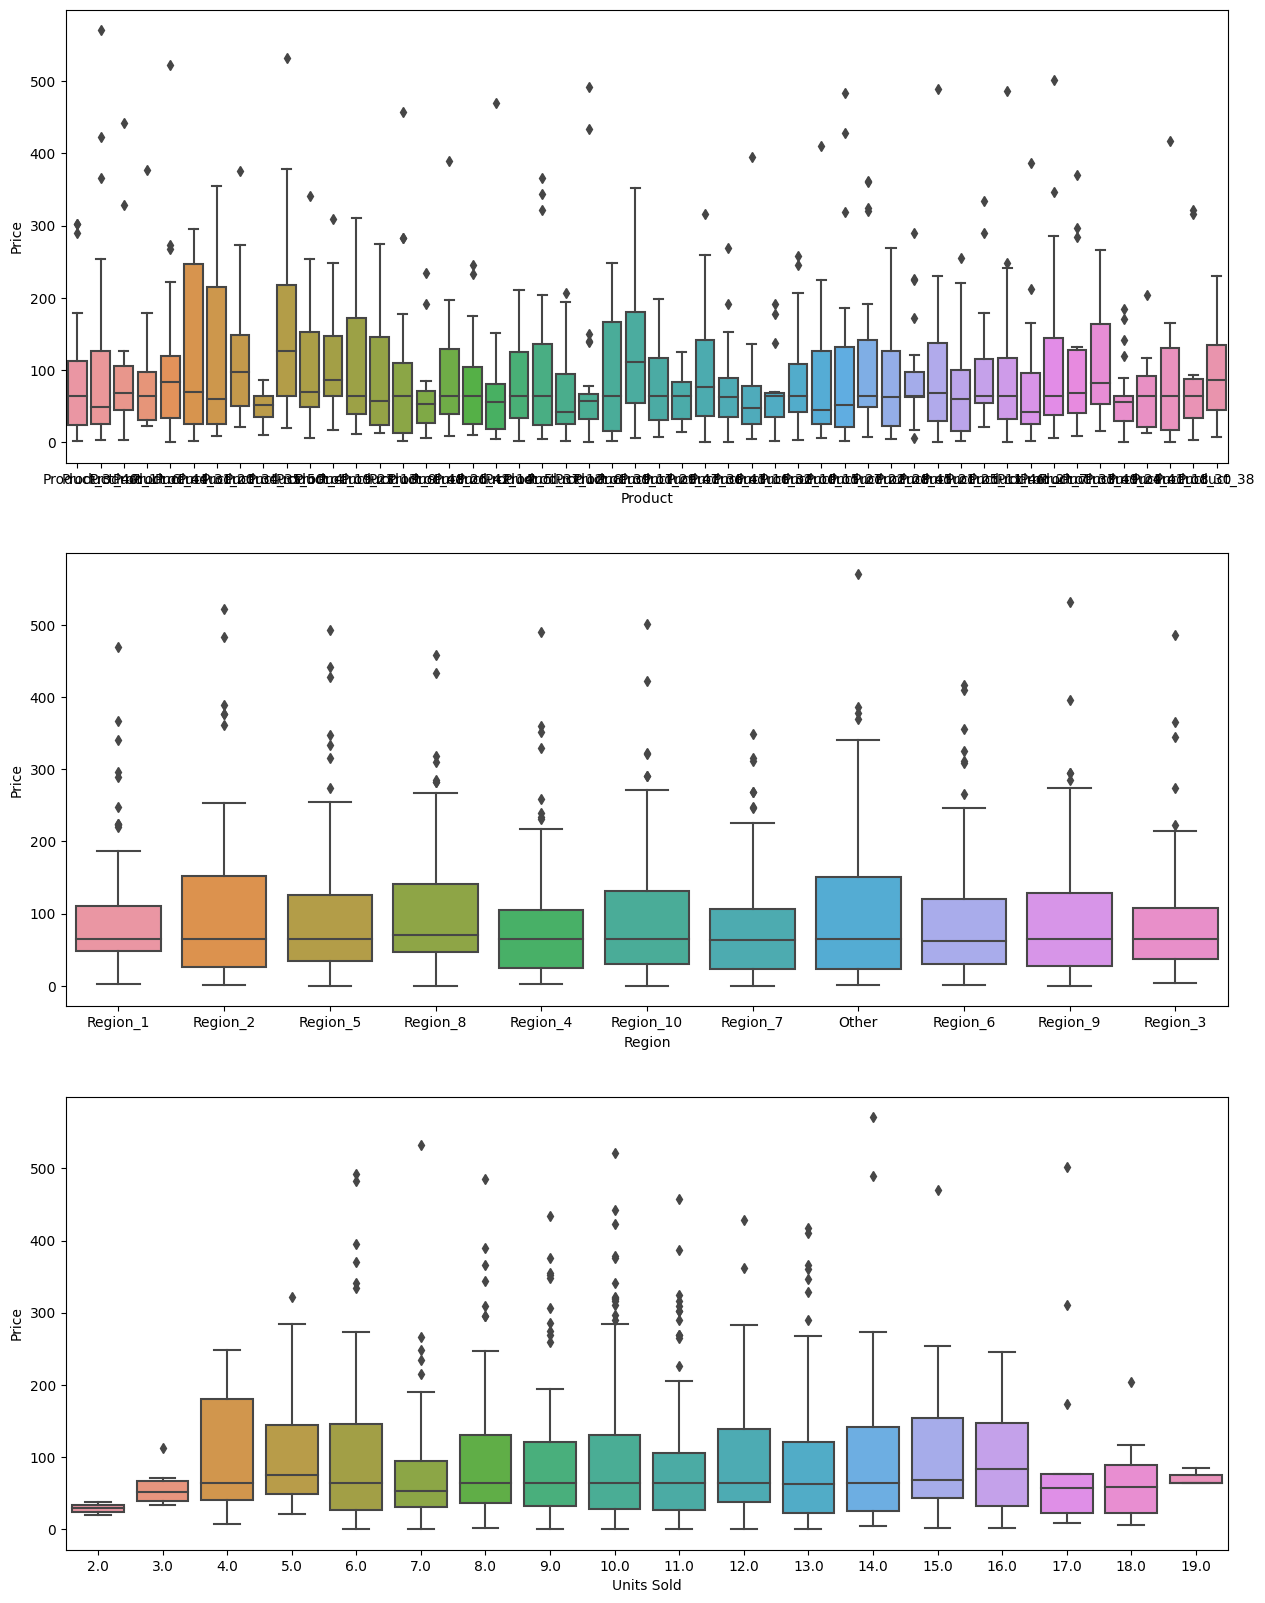

In [119]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1, figsize=(15,20))

sns.boxplot(x='Product',y='Price', data=df, ax=ax1)
sns.boxplot(x='Region',y='Price', data=df, ax=ax2)
sns.boxplot(x='Units Sold',y='Price', data=df, ax=ax3)

For the sake of looking through an end-to-end regression model, lets look at our assignment 3 dataset: 

### Regression

In [120]:
df3 = pd.read_csv('/Users/mahinbindra/Downloads/kc_house_data (1).csv')

Lets start with some exploratory analysis:


In [121]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [122]:
df3['date'] = pd.to_datetime(df3['date'])

In [123]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [124]:
df3.describe(include='all').transpose()

count                           mean                  min   
id             21613.0              4580301520.864988            1000102.0  \
date             21613  2014-10-29 04:38:01.959931648  2014-05-02 00:00:00   
price          21613.0                  540088.141767              75000.0   
bedrooms       21613.0                       3.370842                  0.0   
bathrooms      21613.0                       2.114757                  0.0   
sqft_living    21613.0                    2079.899736                290.0   
sqft_lot       21613.0                   15106.967566                520.0   
floors         21613.0                       1.494309                  1.0   
waterfront     21613.0                       0.007542                  0.0   
view           21613.0                       0.234303                  0.0   
condition      21613.0                        3.40943                  1.0   
grade          21613.0                       7.656873                  1.0   
sqft_above     21613.0                    1788.390691                290.0   
sqft_basement  21613.0                     291.509045                  0.0   
yr_built       21613.0                    1971.005136               1900.0   
yr_renovated   21613.0                      84.402258                  0.0   
zipcode        21613.0                   98077.939805              98001.0   
lat            21613.0                      47.560053              47.1559   
long           21613.0                    -122.213896             -122.519   
sqft_living15  21613.0                    1986.552492                399.0   
sqft_lot15     21613.0                   12768.455652                651.0   

                               25%                  50%                  75%   
id                    2123049194.0         3904930410.0         7308900445.0  \
date           2014-07-22 00:00:00  2014-10-16 00:00:00  2015-02-17 00:00:00   
price                     321950.0             450000.0             645000.0   
bedrooms                       3.0                  3.0                  4.0   
bathrooms                     1.75                 2.25                  2.5   
sqft_living                 1427.0               1910.0               2550.0   
sqft_lot                    5040.0               7618.0              10688.0   
floors                         1.0                  1.5                  2.0   
waterfront                     0.0                  0.0                  0.0   
view                           0.0                  0.0                  0.0   
condition                      3.0                  3.0                  4.0   
grade                          7.0                  7.0                  8.0   
sqft_above                  1190.0               1560.0               2210.0   
sqft_basement                  0.0                  0.0                560.0   
yr_built                    1951.0               1975.0               1997.0   
yr_renovated                   0.0                  0.0                  0.0   
zipcode                    98033.0              98065.0              98118.0   
lat                         47.471              47.5718               47.678   
long                      -122.328              -122.23             -122.125   
sqft_living15               1490.0               1840.0               2360.0   
sqft_lot15                  5100.0               7620.0              10083.0   

                               max                std  
id                    9900000190.0  2876565571.312057  
date           2015-05-27 00:00:00                NaN  
price                    7700000.0      367127.196483  
bedrooms                      33.0           0.930062  
bathrooms                      8.0           0.770163  
sqft_living                13540.0         918.440897  
sqft_lot                 1651359.0       41420.511515  
floors                         3.5           0.539989  
waterfront                     1.0 

In [125]:
df3.head()

id       date     price  bedrooms  bathrooms  sqft_living   
0  7129300520 2014-10-13  221900.0         3       1.00         1180  \
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement   
0      5650     1.0           0     0  ...      7        1180              0  \
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15   
0      1955             0    98178  47.5112 -122.257           1340  \
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

Our target is price

In [126]:
numerical_cols = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15','sqft_above','sqft_basement']
categorical_cols = ['waterfront','view','condition','grade']

But first lets get rid of some outliers

In [127]:
for column in numerical_cols:
    skewness_values = []
    s = skew(df3[column])
    k = kurtosis(df3[column])
    print(f'{column}: skewness = {s}, kurtosis = {k}')
if abs(s) > 1:
    df3[column] = df3[column].apply(lambda x: np.log(x + 1))
z_scores = zscore(df3[numerical_cols])
threshold=3
df3 = df3[(np.abs(z_scores) < threshold).all(axis=1)]

bedrooms: skewness = 1.9741625111266883, kurtosis = 49.05202582325276
bathrooms: skewness = 0.5110721004310892, kurtosis = 1.2793287699931106
sqft_living: skewness = 1.4714532949510901, kurtosis = 5.241602521613769
sqft_lot: skewness = 13.059112541314752, kurtosis = 285.01159582778826
floors: skewness = 0.6161339560208519, kurtosis = -0.48488840505286346
yr_built: skewness = -0.4697727924346707, kurtosis = -0.657533026308136
yr_renovated: skewness = 4.549177613900141, kurtosis = 18.696548433414677
zipcode: skewness = 0.40563305372416186, kurtosis = -0.8535590381317446
lat: skewness = -0.48523679681994325, kurtosis = -0.6764341498242992
long: skewness = 0.8849915572046252, kurtosis = 1.0489805112706225
sqft_living15: skewness = 1.108104363669749, kurtosis = 1.5964487608061324
sqft_lot15: skewness = 9.50608344063878, kurtosis = 150.72795683083365
sqft_above: skewness = 1.4465640690628738, kurtosis = 3.4012389779605696
sqft_basement: skewness = 1.577855538493433, kurtosis = 2.714668427210

In [128]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19512 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19512 non-null  int64         
 1   date           19512 non-null  datetime64[ns]
 2   price          19512 non-null  float64       
 3   bedrooms       19512 non-null  int64         
 4   bathrooms      19512 non-null  float64       
 5   sqft_living    19512 non-null  int64         
 6   sqft_lot       19512 non-null  int64         
 7   floors         19512 non-null  float64       
 8   waterfront     19512 non-null  int64         
 9   view           19512 non-null  int64         
 10  condition      19512 non-null  int64         
 11  grade          19512 non-null  int64         
 12  sqft_above     19512 non-null  int64         
 13  sqft_basement  19512 non-null  float64       
 14  yr_built       19512 non-null  int64         
 15  yr_renovated   19512 non

### Continuous Variable exploration:

<Axes: xlabel='sqft_basement', ylabel='Count'>

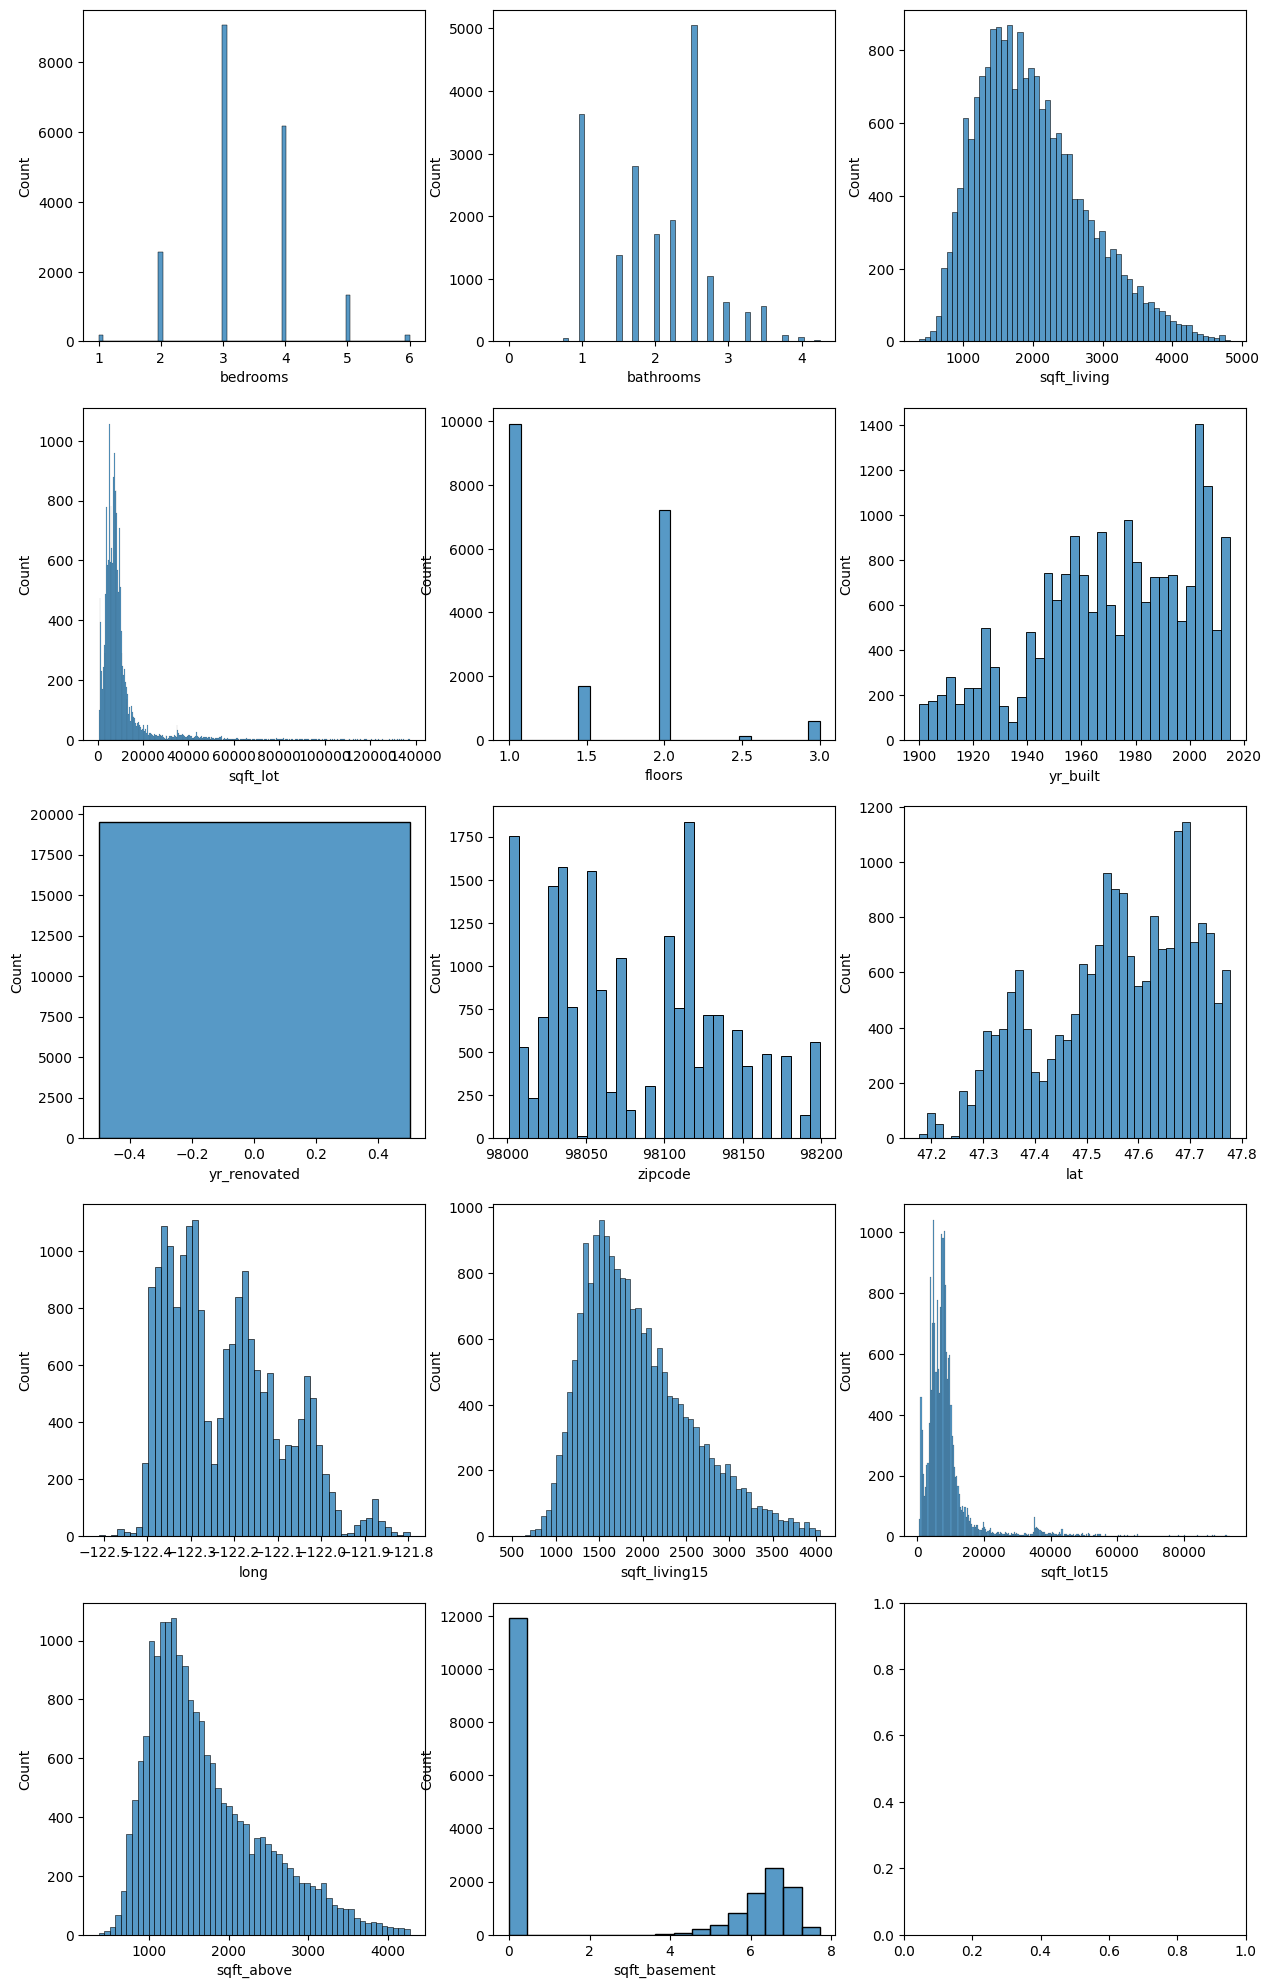

In [129]:
fig, axs = plt.subplots(5,3, figsize=(15,25))
sns.histplot(df3['bedrooms'], ax=axs[0][0])
sns.histplot(df3['bathrooms'], ax=axs[0][1])
sns.histplot(df3['sqft_living'], ax=axs[0][2])
sns.histplot(df3['sqft_lot'], ax=axs[1][0])
sns.histplot(df3['floors'], ax=axs[1][1])
sns.histplot(df3['yr_built'], ax=axs[1][2])
sns.histplot(df3['yr_renovated'], ax=axs[2][0])
sns.histplot(df3['zipcode'], ax=axs[2][1])
sns.histplot(df3['lat'], ax=axs[2][2])
sns.histplot(df3['long'], ax=axs[3][0])
sns.histplot(df3['sqft_living15'], ax=axs[3][1])
sns.histplot(df3['sqft_lot15'], ax=axs[3][2])
sns.histplot(df3['sqft_above'], ax=axs[4][0])
sns.histplot(df3['sqft_basement'], ax=axs[4][1])

<Axes: xlabel='price', ylabel='sqft_basement'>

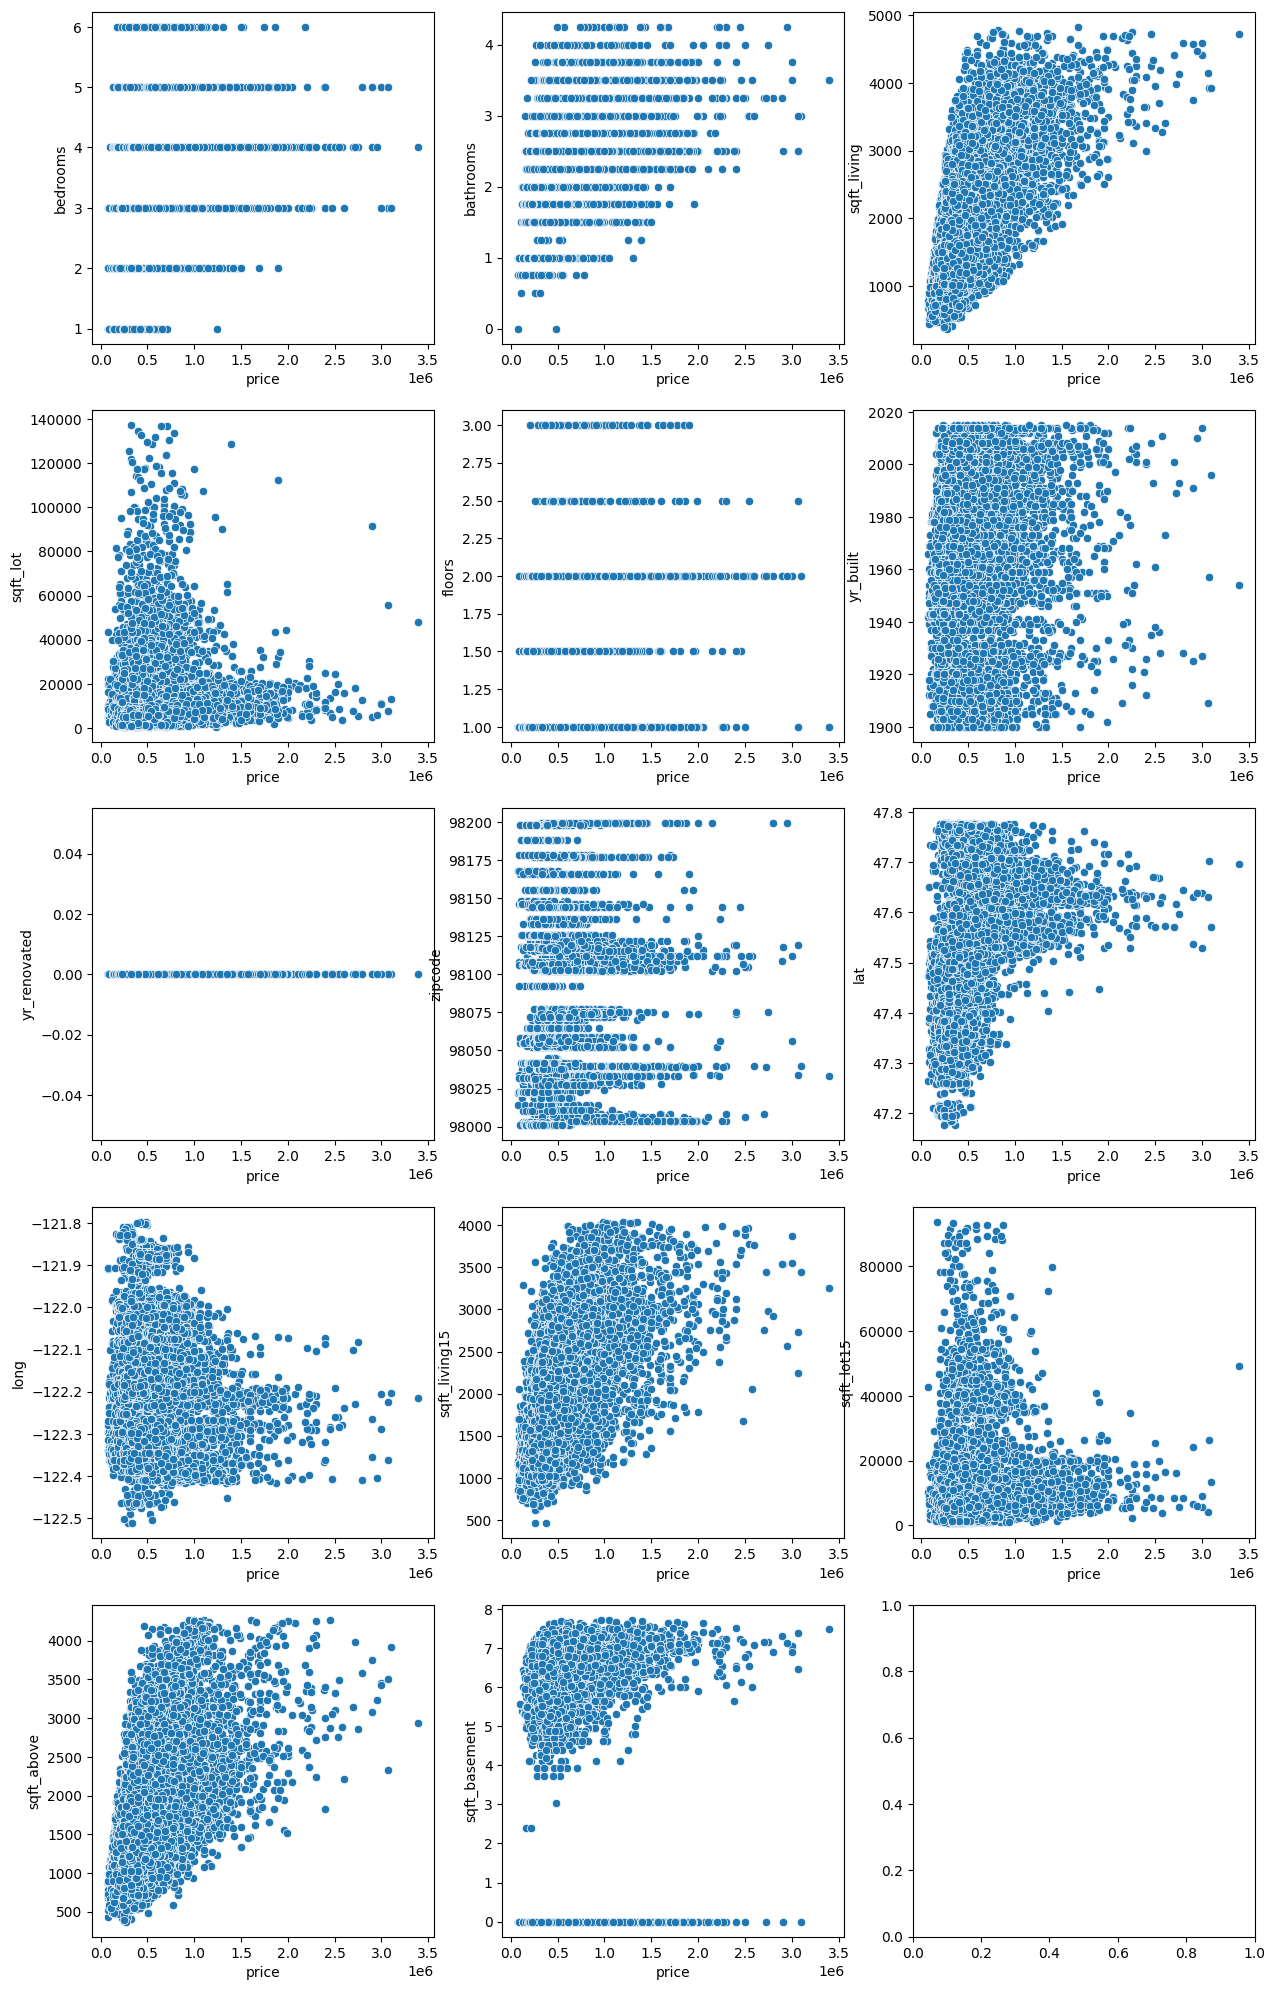

In [130]:
fig, axs = plt.subplots(5,3, figsize=(15,25))
sns.scatterplot(x=df3['price'], y=df3['bedrooms'], ax=axs[0][0])
sns.scatterplot(x=df3['price'], y=df3['bathrooms'], ax=axs[0][1])
sns.scatterplot(x=df3['price'], y=df3['sqft_living'], ax=axs[0][2])
sns.scatterplot(x=df3['price'], y=df3['sqft_lot'], ax=axs[1][0])
sns.scatterplot(x=df3['price'], y=df3['floors'], ax=axs[1][1])
sns.scatterplot(x=df3['price'], y=df3['yr_built'], ax=axs[1][2])
sns.scatterplot(x=df3['price'], y=df3['yr_renovated'], ax=axs[2][0])
sns.scatterplot(x=df3['price'], y=df3['zipcode'], ax=axs[2][1])
sns.scatterplot(x=df3['price'], y=df3['lat'], ax=axs[2][2])
sns.scatterplot(x=df3['price'], y=df3['long'], ax=axs[3][0])
sns.scatterplot(x=df3['price'], y=df3['sqft_living15'], ax=axs[3][1])
sns.scatterplot(x=df3['price'], y=df3['sqft_lot15'], ax=axs[3][2])
sns.scatterplot(x=df3['price'], y=df3['sqft_above'], ax=axs[4][0])
sns.scatterplot(x=df3['price'], y=df3['sqft_basement'], ax=axs[4][1])

## Initial Hypothesis: 
bathroom, sqft_living, sqft_living15, sqft_above, lat, long may be strong predictors of Price. 

### Categorical variable exploration:

In [136]:
categorical_cols

['waterfront', 'view', 'condition', 'grade']

<Axes: xlabel='grade', ylabel='price'>

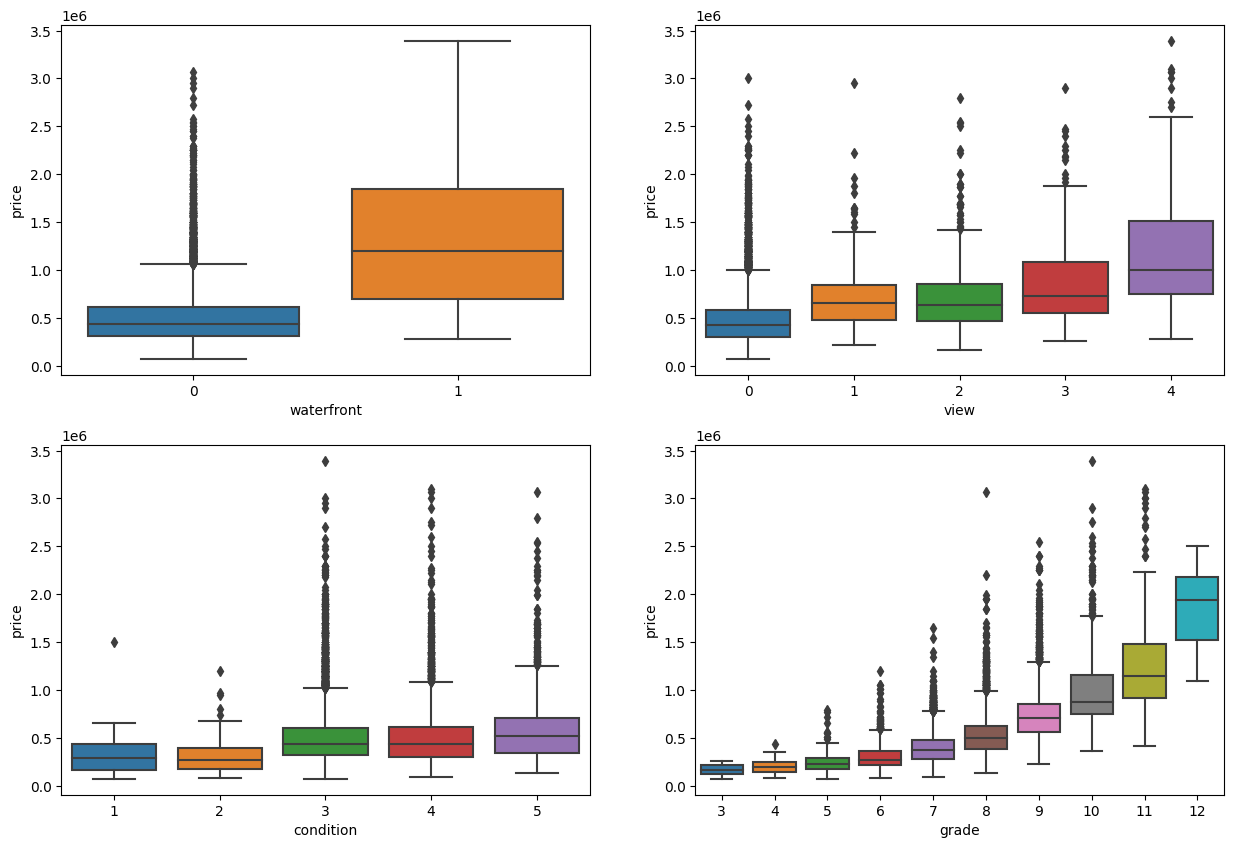

In [137]:
#Continuous vs Categorical target
fig, axs = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(y=df3['price'], x=df3['waterfront'], ax=axs[0][0])
sns.boxplot(y=df3['price'], x=df3['view'], ax=axs[0][1])
sns.boxplot(y=df3['price'], x=df3['condition'], ax=axs[1][0])
sns.boxplot(y=df3['price'], x=df3['grade'], ax=axs[1][1])

### They all looks like strong predictors of price

In [138]:
results = ols("price ~ bathrooms + sqft_living + sqft_living15 + sqft_above + lat + long + waterfront + view + condition + grade", data=df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     3694.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:27:23   Log-Likelihood:            -2.6213e+05
No. Observations:               19512   AIC:                         5.243e+05
Df Residuals:                   19501   BIC:                         5.244e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.773e+07   1.32e+06    -43.639

lets keep the strongest ones for simplicity

In [139]:
#sqft_living is important as per delina, so should include that also
results = ols("price ~ bathrooms + lat + long + waterfront + view + condition + grade", data=df3).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     4198.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:29:31   Log-Likelihood:            -2.6354e+05
No. Observations:               19512   AIC:                         5.271e+05
Df Residuals:                   19504   BIC:                         5.271e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.123e+07    1.3e+06    -31.643      0.0

In [140]:
"y_hat = -4.123e+07 + 5.136e+04*bathrooms + 6.314e+05*lat - 8.452e+04*long + 4.55e+05*waterfront + 7.238e+04*view + 6.547e+04*condition + 1.353e+05*grade"

'y_hat = -4.123e+07 + 5.136e+04*bathrooms + 6.314e+05*lat - 8.452e+04*long + 4.55e+05*waterfront + 7.238e+04*view + 6.547e+04*condition + 1.353e+05*grade'

In [141]:
-4.123e+07 + 5.136e+04*1 + 6.314e+05*47.5112 - 8.452e+04*-122.257 + 4.55e+05*0 + 7.238e+04*0 + 6.547e+04*3 + 1.353e+05*7

296603.3200000003

In [142]:
df3.head()

id       date     price  bedrooms  bathrooms  sqft_living   
0  7129300520 2014-10-13  221900.0         3       1.00         1180  \
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   
6  1321400060 2014-06-27  257500.0         3       2.25         1715   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement   
0      5650     1.0           0     0  ...      7        1180       0.000000  \
2     10000     1.0           0     0  ...      6         770       0.000000   
3      5000     1.0           0     0  ...      7        1050       6.814543   
4      8080     1.0           0     0  ...      8        1680       0.000000   
6      6819     2.0           0     0  ...      7        1715       0.000000   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15   
0      1955             0    98178  47.5112 -122.257           1340  \
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   
6      1995             0    98003  47.3097 -122.327           2238   

   sqft_lot15  
0        5650  
2        8062  
3        5000  
4        7503  
6        6819  

[5 rows x 21 columns]

In [143]:
pred_vals = results.predict(df3[['bathrooms','lat','long','waterfront','view','condition','grade']])


In [144]:
pred_vals

0        299008.320706
2        304770.486751
3        550221.673759
4        534462.548292
6        241903.169769
             ...      
21608    637672.467658
21609    519948.218498
21610    342248.579819
21611    510209.056845
21612    342059.168396
Length: 19512, dtype: float64

In [145]:
res = pd.concat([pred_vals.to_frame().rename(columns={0:'y_hat'}),df3['price']], axis=1)

In [146]:
res

y_hat     price
0      299008.320706  221900.0
2      304770.486751  180000.0
3      550221.673759  604000.0
4      534462.548292  510000.0
6      241903.169769  257500.0
...              ...       ...
21608  637672.467658  360000.0
21609  519948.218498  400000.0
21610  342248.579819  402101.0
21611  510209.056845  400000.0
21612  342059.168396  325000.0

[19512 rows x 2 columns]

In [147]:
res['error'] = res['y_hat'] - res['price']

In [148]:
res['sq_error'] = res['error']**2

In [149]:
np.sqrt(res['sq_error'].mean())

177616.74632958396

(array([7.0000e+00, 2.1000e+01, 3.3000e+01, 1.1800e+02, 4.2200e+02,
        4.0800e+03, 1.3854e+04, 9.6000e+02, 1.6000e+01, 1.0000e+00]),
 array([-1869673.1193148 , -1570611.25213238, -1271549.38494997,
         -972487.51776755,  -673425.65058514,  -374363.78340272,
          -75301.91622031,   223759.95096211,   522821.81814452,
          821883.68532694,  1120945.55250935]),
 <BarContainer object of 10 artists>)

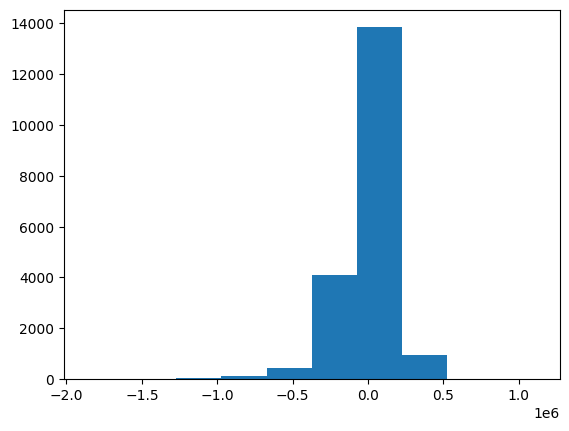

In [150]:
plt.hist(res['error'])

(array([8.551e+03, 8.075e+03, 2.129e+03, 4.660e+02, 1.660e+02, 7.100e+01,
        2.800e+01, 1.500e+01, 7.000e+00, 4.000e+00]),
 array([  75000.,  407000.,  739000., 1071000., 1403000., 1735000.,
        2067000., 2399000., 2731000., 3063000., 3395000.]),
 <BarContainer object of 10 artists>)

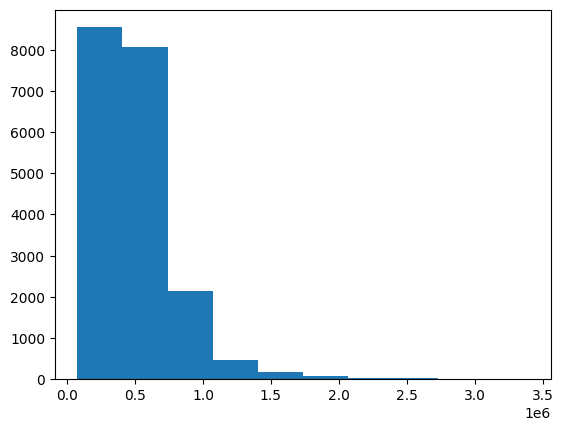

In [320]:
plt.hist(df3['price'])

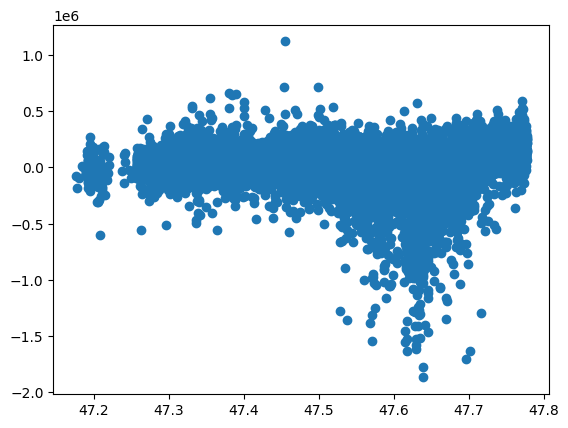

In [151]:
plt.scatter(df3['lat'],res['error'])

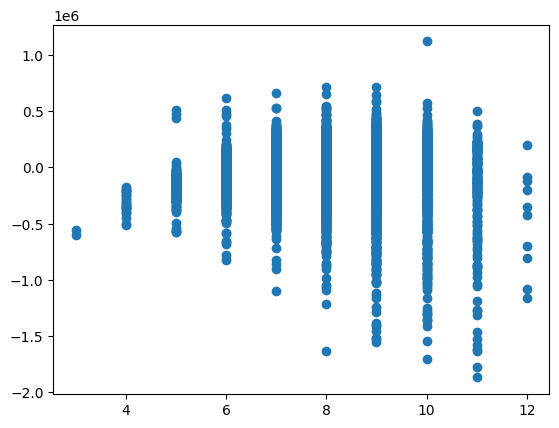

In [322]:
plt.scatter(df3['grade'],res['error'])

((array([-3.97275191, -3.75628434, -3.63782151, ...,  3.63782151,
          3.75628434,  3.97275191]),
  array([-1869673.1193148 , -1777322.93451231, -1703425.97213169, ...,
           711739.33496199,   718929.59794756,  1120945.55250935])),
 (165126.7951035322, 6.155271953507337e-08, 0.9294987299652144))

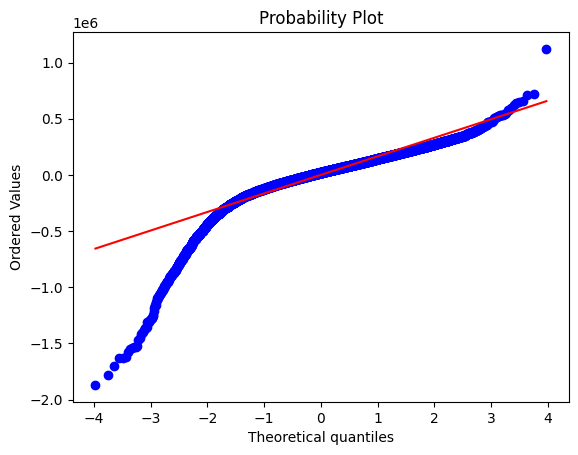

In [152]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(res['error'], dist='norm', plot=ax)

In [153]:
infl = results.get_influence()
print(infl.summary_frame())

       dfb_Intercept  dfb_bathrooms   dfb_lat  dfb_long  dfb_waterfront   
0          -0.000402       0.004802  0.001322  0.000068        0.000012  \
2          -0.000359       0.003747 -0.007320 -0.002791       -0.000066   
3          -0.003207       0.005376 -0.000626 -0.003435        0.000140   
4          -0.001204       0.000628 -0.000521 -0.001393       -0.000035   
6          -0.000344       0.000505 -0.001160 -0.000751       -0.000005   
...              ...            ...       ...       ...             ...   
21608       0.015852      -0.008265 -0.009253  0.012849       -0.000837   
21609       0.006147      -0.003269  0.002781  0.007164       -0.000225   
21610      -0.000566      -0.004635  0.000255 -0.000498        0.000016   
21611      -0.004374      -0.001314  0.000210 -0.004331       -0.000150   
21612       0.000161       0.001321 -0.000071  0.000142       -0.000005   

       dfb_view  dfb_condition  dfb_grade       cooks_d  standard_resid   
0      0.000310       0.

In [154]:
infl.summary_frame()

dfb_Intercept  dfb_bathrooms   dfb_lat  dfb_long  dfb_waterfront   
0          -0.000402       0.004802  0.001322  0.000068        0.000012  \
2          -0.000359       0.003747 -0.007320 -0.002791       -0.000066   
3          -0.003207       0.005376 -0.000626 -0.003435        0.000140   
4          -0.001204       0.000628 -0.000521 -0.001393       -0.000035   
6          -0.000344       0.000505 -0.001160 -0.000751       -0.000005   
...              ...            ...       ...       ...             ...   
21608       0.015852      -0.008265 -0.009253  0.012849       -0.000837   
21609       0.006147      -0.003269  0.002781  0.007164       -0.000225   
21610      -0.000566      -0.004635  0.000255 -0.000498        0.000016   
21611      -0.004374      -0.001314  0.000210 -0.004331       -0.000150   
21612       0.000161       0.001321 -0.000071  0.000142       -0.000005   

       dfb_view  dfb_condition  dfb_grade       cooks_d  standard_resid   
0      0.000310       0.002420  -0.001629  5.303958e-06       -0.434087  \
2     -0.000898       0.004478   0.004993  2.147766e-05       -0.702449   
3     -0.001353       0.005126  -0.002745  8.560950e-06        0.302828   
4      0.000090       0.000504  -0.000344  4.750330e-07       -0.137712   
6     -0.000183      -0.000468  -0.000357  3.316750e-07        0.087809   
...         ...            ...        ...           ...             ...   
21608  0.005271       0.006848   0.000261  6.517607e-05       -1.563170   
21609  0.002528       0.002998  -0.000981  1.216616e-05       -0.675254   
21610 -0.000294      -0.001952   0.001799  4.294407e-06        0.336957   
21611  0.000725       0.002198   0.000401  6.962705e-06       -0.620406   
21612  0.000084       0.000556  -0.000513  3.488363e-07       -0.096040   

       hat_diag  dffits_internal  student_resid    dffits  
0      0.000225        -0.006514      -0.434078 -0.006514  
2      0.000348        -0.013108      -0.702439 -0.013108  
3      0.000746         0.008276       0.302821  0.008276  
4      0.000200        -0.001949      -0.137709 -0.001949  
6      0.000344         0.001629       0.087807  0.001629  
...         ...              ...            ...       ...  
21608  0.000213        -0.022834      -1.563228 -0.022835  
21609  0.000213        -0.009866      -0.675245 -0.009865  
21610  0.000302         0.005861       0.336949  0.005861  
21611  0.000145        -0.007463      -0.620396 -0.007463  
21612  0.000302        -0.001671      -0.096037 -0.001670  

[19512 rows x 14 columns]

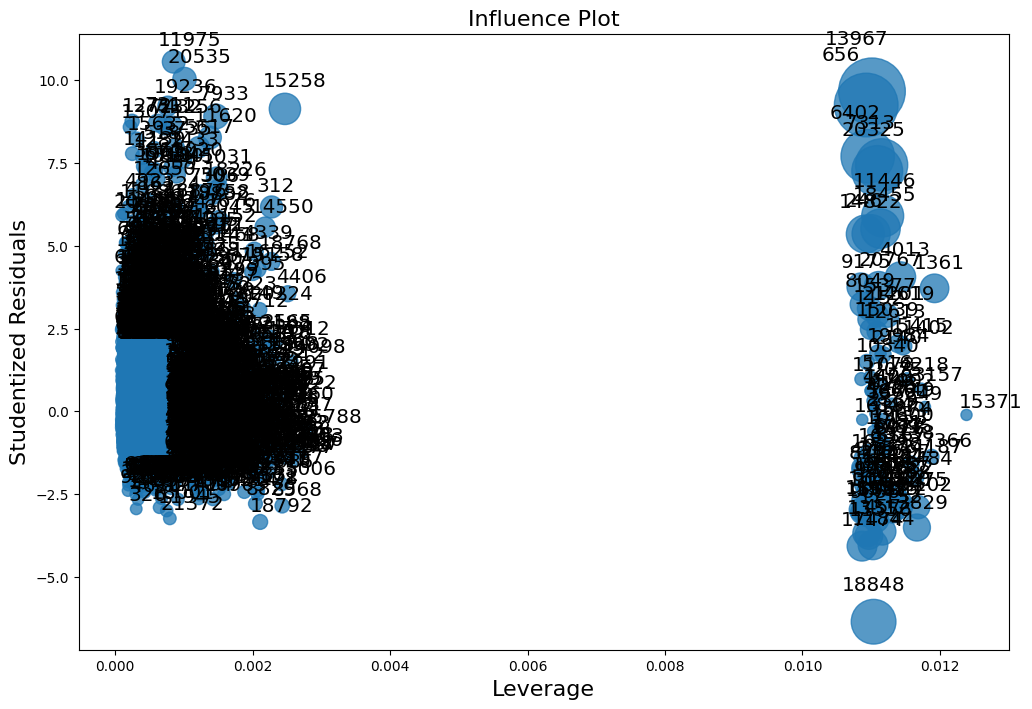

In [155]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion='cooks')

Ideally we should drop the points at top right corner at this point but skipping that here. 

In [156]:
df4 = df3.copy()

In [157]:
df4.drop([13967, 656, 6402, 20325, 7313], inplace=True)

In [158]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19507 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19507 non-null  int64         
 1   date           19507 non-null  datetime64[ns]
 2   price          19507 non-null  float64       
 3   bedrooms       19507 non-null  int64         
 4   bathrooms      19507 non-null  float64       
 5   sqft_living    19507 non-null  int64         
 6   sqft_lot       19507 non-null  int64         
 7   floors         19507 non-null  float64       
 8   waterfront     19507 non-null  int64         
 9   view           19507 non-null  int64         
 10  condition      19507 non-null  int64         
 11  grade          19507 non-null  int64         
 12  sqft_above     19507 non-null  int64         
 13  sqft_basement  19507 non-null  float64       
 14  yr_built       19507 non-null  int64         
 15  yr_renovated   19507 non

In [159]:
results = ols("price ~ bathrooms + lat + long + waterfront + view + condition + grade", data=df4).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     4173.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:50:11   Log-Likelihood:            -2.6329e+05
No. Observations:               19507   AIC:                         5.266e+05
Df Residuals:                   19499   BIC:                         5.267e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.125e+07   1.29e+06    -31.952      0.0

In [160]:
infl = results.get_influence()
print(infl.summary_frame())

       dfb_Intercept  dfb_bathrooms   dfb_lat  dfb_long  dfb_waterfront   
0          -0.000407       0.004872  0.001342  0.000069        0.000023  \
2          -0.000364       0.003795 -0.007417 -0.002828       -0.000038   
3          -0.003205       0.005373 -0.000625 -0.003433        0.000125   
4          -0.001194       0.000623 -0.000516 -0.001381       -0.000038   
6          -0.000331       0.000486 -0.001116 -0.000722       -0.000008   
...              ...            ...       ...       ...             ...   
21608       0.015979      -0.008332 -0.009328  0.012952       -0.000856   
21609       0.006202      -0.003297  0.002806  0.007228       -0.000224   
21610      -0.000568      -0.004653  0.000255 -0.000500        0.000009   
21611      -0.004402      -0.001322  0.000211 -0.004359       -0.000159   
21612       0.000166       0.001358 -0.000073  0.000146       -0.000003   

       dfb_view  dfb_condition  dfb_grade       cooks_d  standard_resid   
0      0.000314       0.

In [161]:
infl.summary_frame()

dfb_Intercept  dfb_bathrooms   dfb_lat  dfb_long  dfb_waterfront   
0          -0.000407       0.004872  0.001342  0.000069        0.000023  \
2          -0.000364       0.003795 -0.007417 -0.002828       -0.000038   
3          -0.003205       0.005373 -0.000625 -0.003433        0.000125   
4          -0.001194       0.000623 -0.000516 -0.001381       -0.000038   
6          -0.000331       0.000486 -0.001116 -0.000722       -0.000008   
...              ...            ...       ...       ...             ...   
21608       0.015979      -0.008332 -0.009328  0.012952       -0.000856   
21609       0.006202      -0.003297  0.002806  0.007228       -0.000224   
21610      -0.000568      -0.004653  0.000255 -0.000500        0.000009   
21611      -0.004402      -0.001322  0.000211 -0.004359       -0.000159   
21612       0.000166       0.001358 -0.000073  0.000146       -0.000003   

       dfb_view  dfb_condition  dfb_grade       cooks_d  standard_resid   
0      0.000314       0.002455  -0.001652  5.460397e-06       -0.440413  \
2     -0.000910       0.004537   0.005063  2.205973e-05       -0.711813   
3     -0.001352       0.005124  -0.002745  8.552538e-06        0.302664   
4      0.000089       0.000499  -0.000341  4.668405e-07       -0.136513   
6     -0.000176      -0.000450  -0.000344  3.069887e-07        0.084470   
...         ...            ...        ...           ...             ...   
21608  0.005313       0.006904   0.000261  6.623119e-05       -1.575699   
21609  0.002551       0.003025  -0.000990  1.238652e-05       -0.681312   
21610 -0.000295      -0.001960   0.001805  4.327865e-06        0.338252   
21611  0.000730       0.002213   0.000402  7.053288e-06       -0.624403   
21612  0.000086       0.000572  -0.000527  3.688492e-07       -0.098752   

       hat_diag  dffits_internal  student_resid    dffits  
0      0.000225        -0.006609      -0.440403 -0.006609  
2      0.000348        -0.013284      -0.711804 -0.013284  
3      0.000746         0.008272       0.302656  0.008271  
4      0.000200        -0.001933      -0.136510 -0.001932  
6      0.000344         0.001567       0.084468  0.001567  
...         ...              ...            ...       ...  
21608  0.000213        -0.023018      -1.575759 -0.023019  
21609  0.000213        -0.009955      -0.681302 -0.009954  
21610  0.000303         0.005884       0.338244  0.005884  
21611  0.000145        -0.007512      -0.624393 -0.007512  
21612  0.000302        -0.001718      -0.098749 -0.001718  

[19507 rows x 14 columns]

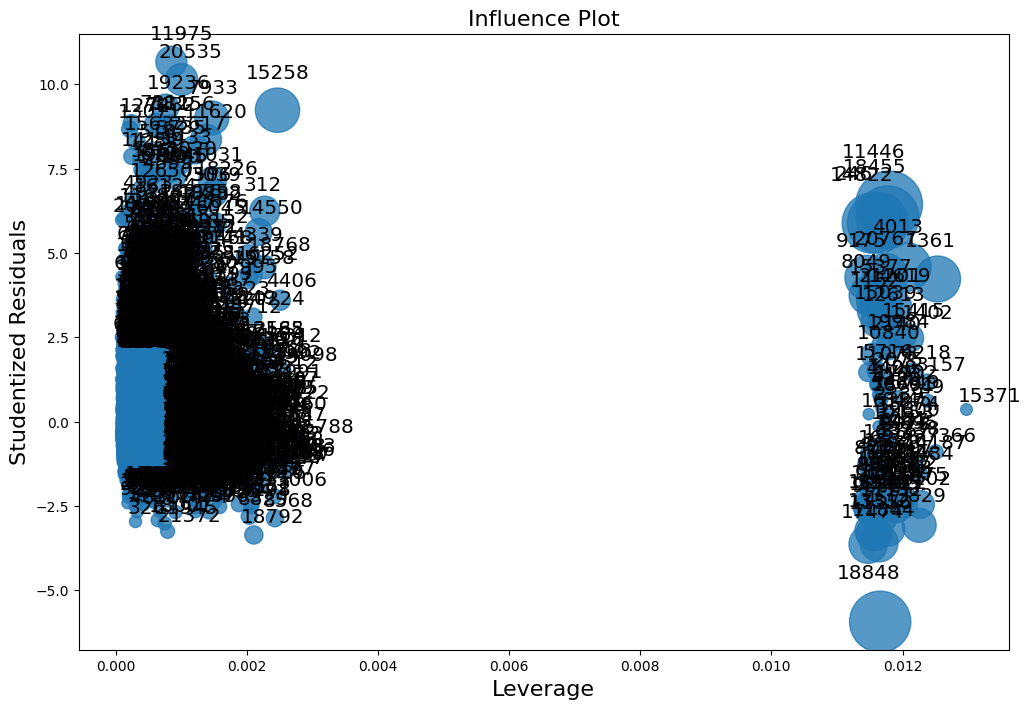

In [162]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion='cooks')

In [163]:
res

y_hat     price          error      sq_error
0      299008.320706  221900.0   77108.320706  5.945693e+09
2      304770.486751  180000.0  124770.486751  1.556767e+10
3      550221.673759  604000.0  -53778.326241  2.892108e+09
4      534462.548292  510000.0   24462.548292  5.984163e+08
6      241903.169769  257500.0  -15596.830231  2.432611e+08
...              ...       ...            ...           ...
21608  637672.467658  360000.0  277672.467658  7.710200e+10
21609  519948.218498  400000.0  119948.218498  1.438758e+10
21610  342248.579819  402101.0  -59852.420181  3.582312e+09
21611  510209.056845  400000.0  110209.056845  1.214604e+10
21612  342059.168396  325000.0   17059.168396  2.910152e+08

[19512 rows x 4 columns]

[You can manually add dummies as seen in the FE section](#dummy_var)

i'm skipping here and i'll be onehoteencoding later

In [164]:
numerical_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_above',
 'sqft_basement']

In [165]:
categorical_cols

['waterfront', 'view', 'condition', 'grade']

In [166]:
target = 'price'

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df3[categorical_cols + numerical_cols]
                                                    ,df3[target],
                                                    test_size = 0.3, random_state=1234)


In [169]:
cat_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps = [('scaler', StandardScaler())])

In [170]:
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, categorical_cols),
                                                 ('num', num_transformer, numerical_cols)])

In [171]:
linear_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [172]:
linear_regression.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['waterfront', 'view',
                                                   'condition', 'grade']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'yr_built',
                                                   'yr_renovated', 'zipcode',
                                                   'lat', 'long',
                                                   'sqft_living15',
                                                   'sqft_lot15', 'sqft_above',
                                                   'sqft_basement'])])),
                ('regressor', LinearRegression())])

In [173]:
pred = linear_regression.predict(X_test)

In [174]:
from sklearn.metrics import mean_squared_error

In [175]:
np.sqrt(mean_squared_error(pred,y_test))

157015.83696917488

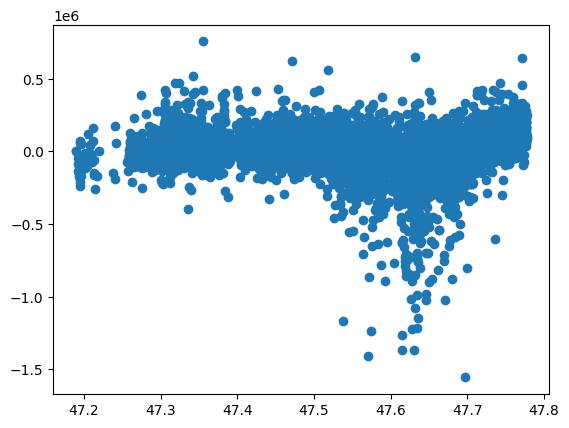

In [176]:
linear_pred_ = pd.concat([pd.DataFrame(pred).rename(columns={0:'pred'}),y_test.reset_index().drop('index',axis=1).rename(columns={0:'actual'})], axis=1)
linear_pred_['res'] = linear_pred_['pred'] - linear_pred_['price']
plt.scatter(X_test['lat'],linear_pred_['res'])

In [177]:
list = numerical_cols + categorical_cols 

In [178]:
list.append('price')

In [179]:
my_dict = {key: 'mean' for key in list}

In [180]:
my_dict

{'bedrooms': 'mean',
 'bathrooms': 'mean',
 'sqft_living': 'mean',
 'sqft_lot': 'mean',
 'floors': 'mean',
 'yr_built': 'mean',
 'yr_renovated': 'mean',
 'zipcode': 'mean',
 'lat': 'mean',
 'long': 'mean',
 'sqft_living15': 'mean',
 'sqft_lot15': 'mean',
 'sqft_above': 'mean',
 'sqft_basement': 'mean',
 'waterfront': 'mean',
 'view': 'mean',
 'condition': 'mean',
 'grade': 'mean',
 'price': 'mean'}

In [181]:
daily_dataset = df3.set_index('date').resample("H").agg(my_dict).ffill()

In [182]:
results = ols("price ~ bathrooms + lat + long + waterfront + view + condition + grade", data=daily_dataset).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     2322.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:07:11   Log-Likelihood:            -1.1482e+05
No. Observations:                9361   AIC:                         2.297e+05
Df Residuals:                    9353   BIC:                         2.297e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.353e+07   1.53e+06    -34.989      0.0

In [183]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [184]:
ridge_regression = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=3.0))
])
ridge_regression.fit(X_train, y_train)
pred_ridge = ridge_regression.predict(X_test)
np.sqrt(mean_squared_error(pred_ridge,y_test))


157263.28883629286

In [185]:
lasso_reg = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=3.0))
])
lasso_reg.fit(X_train, y_train)
pred_lasso = lasso_reg.predict(X_test)
np.sqrt(mean_squared_error(pred_lasso,y_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+12, tolerance: 1.076e+11
  model = cd_fast.enet_coordinate_descent(


157014.48079434113

In [186]:
Elastic_reg = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=3.0,l1_ratio=0.8))
])
Elastic_reg.fit(X_train, y_train)
elastic_pred = Elastic_reg.predict(X_test)

In [187]:
np.sqrt(mean_squared_error(elastic_pred, y_test))

188359.29349688708

Best MSE was Linear Regression so thats the model we pick. 

### Classification 

In [188]:
df5 = sns.load_dataset('titanic')

In [189]:
df5.head()

survived  pclass     sex   age  sibsp  parch     fare embarked  class   
0         0       3    male  22.0      1      0   7.2500        S  Third  \
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

In [190]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [192]:
#Getting rid of unneccessary columns
df5.drop(['alive','alone','embark_town','who','adult_male','deck','class'], axis=1,inplace=True)

In [193]:
#Some quick imputing
df5['age'] = df5['age'].fillna(df5.groupby('sex')['age'].transform('median'))

In [194]:
df5['embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [195]:
df5['embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: embarked, dtype: object

In [196]:
df5['embarked'] = df5['embarked'].fillna('S')

In [197]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [198]:
sex_dummies = pd.get_dummies(df5['sex'])
embarked_dummies = pd.get_dummies(df5['embarked'])
df5 = pd.concat([df5,sex_dummies,embarked_dummies],axis=1)

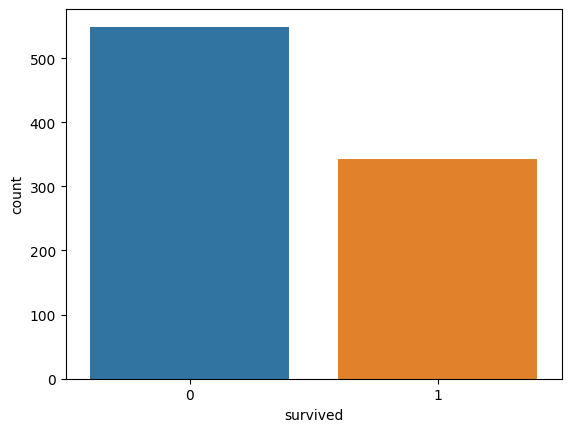

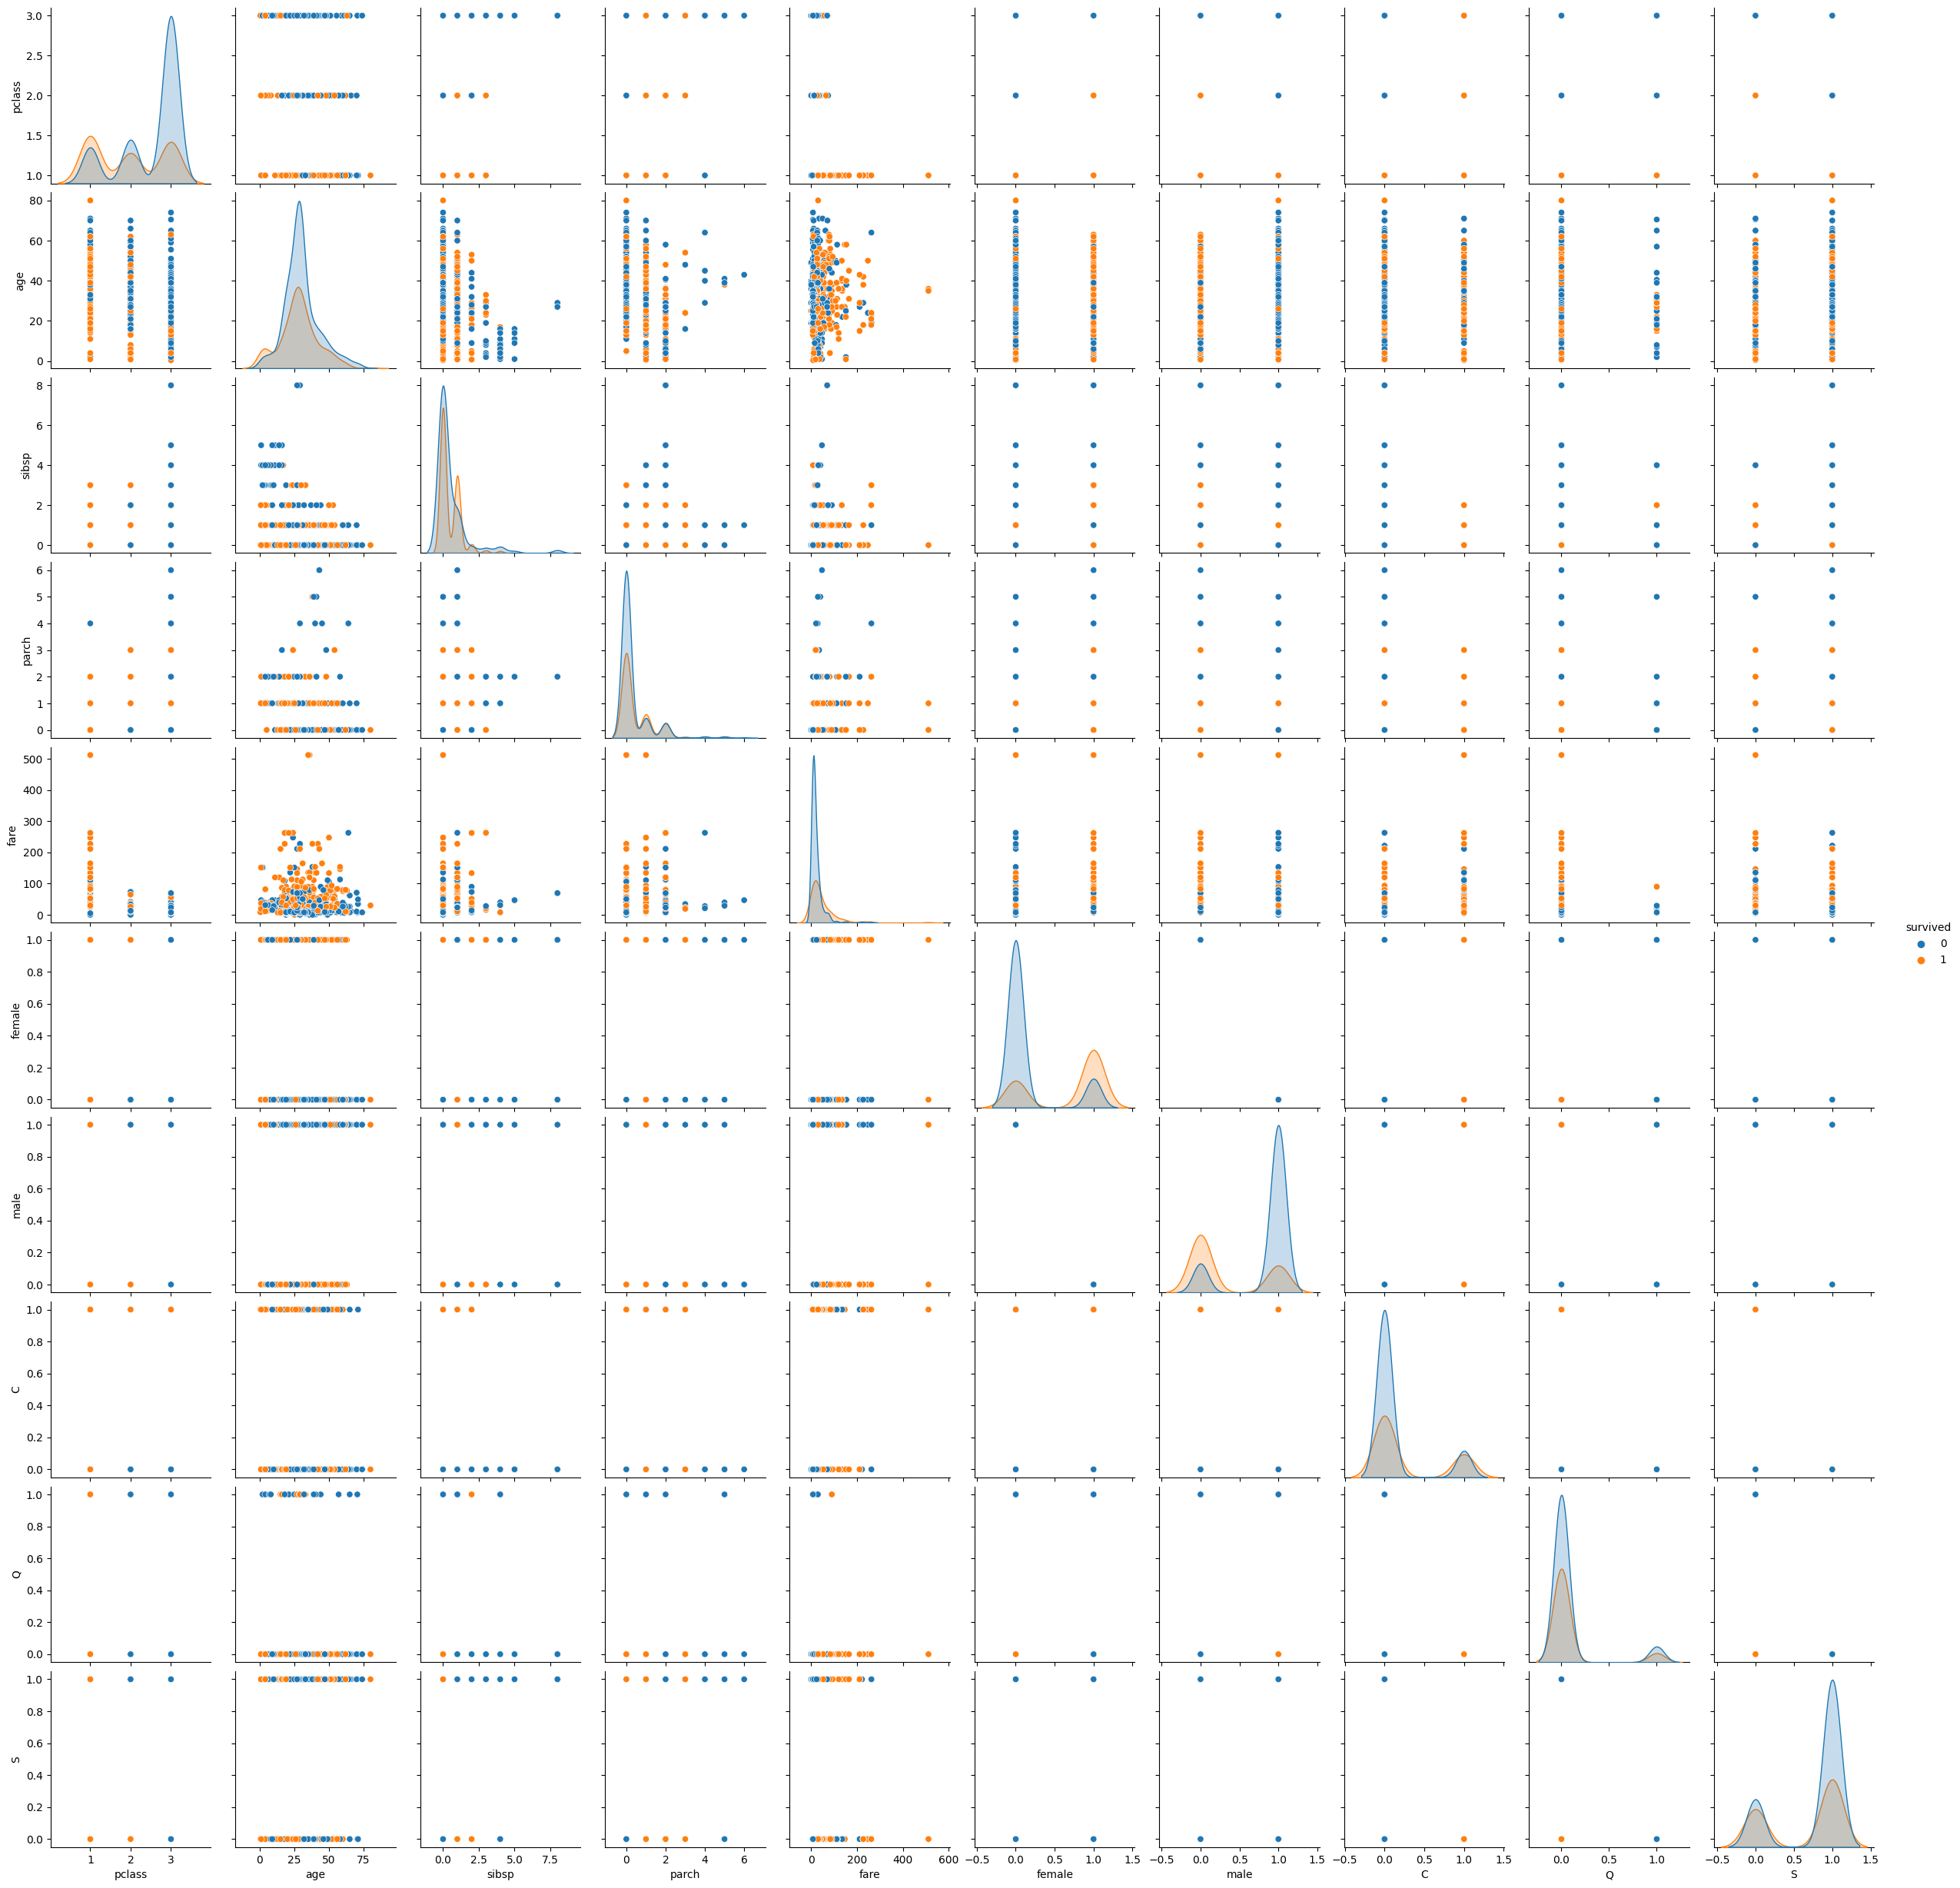

In [199]:
# Some exploration
sns.countplot(x='survived', data=df5)
plt.show()

sns.pairplot(df5, hue='survived')
plt.show()

In [200]:
df5.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'female', 'male', 'C', 'Q', 'S'],
      dtype='object')

In [201]:
cat_columns = ['pclass','sex','embarked']
num_columns = ['age','sibsp','parch','fare']
target = 'survived'

In [202]:
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns),
                                                 ('num', num_transformer, num_columns)])


In [203]:
X_train, X_test, y_train, y_test = train_test_split(df5[cat_columns + num_columns], df5[target], test_size=0.2, random_state=42)


In [204]:
x_train_transformed = preprocessor.fit_transform(X_train)
x_test_transformed = preprocessor.fit_transform(X_test)


In [205]:
x_train_transformed.shape

(712, 12)

In [206]:
x_test_transformed.shape

(179, 12)

In [207]:
encoded_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns)

In [208]:
encoded_columns = encoded_columns.tolist()

In [209]:
all_feat = num_columns + encoded_columns

X_train_transformed = pd.DataFrame(x_train_transformed, columns=all_feat)
X_test_transformed = pd.DataFrame(x_test_transformed, columns=all_feat)


In [210]:
knn = KNeighborsClassifier(n_neighbors = 40)
knn.fit(X_train_transformed, y_train)
y_pred = knn.predict(X_test_transformed)
print(f1_score(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

0.7445255474452555
0.8044692737430168


In [211]:
recall = []

for a in range(1,100):
    knn = KNeighborsClassifier(n_neighbors = a)
    knn.fit(X_train_transformed, y_train)
    y_pred = knn.predict(X_test_transformed)
    # print(f1_score(y_pred, y_test))
    recall.append(recall_score(y_pred, y_test))

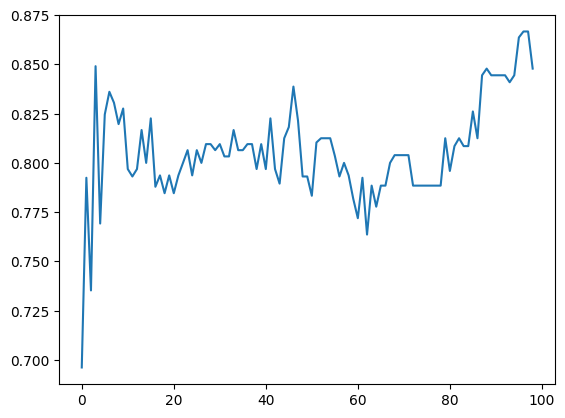

In [212]:
plt.plot(recall)

In [213]:
# Hyperparameter tuning
# select parameters
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
params_knn = {'n_neighbors':range(1,200), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

# Define the models
nb = GaussianNB()
knn = KNeighborsClassifier()

# Define GridSearchCV
gridsearch_knn = GridSearchCV(knn, params_knn, cv=10, scoring='recall')
    #nb, params_nb, cv=5)
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, n_iter = 50, scoring='recall')

# Fit models
gridsearch_knn.fit(X_train_transformed, y_train)
randomsearch_knn.fit(X_train_transformed, y_train)

# Get the best parameters
print("Best parameters for KNN - gridsearch: ", gridsearch_knn.best_params_)
print("Best parameters for KNN - randomsearch: ", randomsearch_knn.best_params_)


Best parameters for KNN - gridsearch:  {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best parameters for KNN - randomsearch:  {'weights': 'distance', 'n_neighbors': 31, 'metric': 'euclidean'}


In [214]:
# Apply the best parameters
#nb_best = GaussianNB(**gridsearch_nb.best_params_)
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# Perform cross-validation
#cv_scores_nb = cross_val_score(nb_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')
cv_scores_knn = cross_val_score(knn_best, X_train_transformed, y_train, cv=10, scoring='precision')

#print("Cross-validation scores for Naive Bayes: ", cv_scores_nb)
print("Cross-validation scores for KNN: ", cv_scores_knn)

# Fit the models with the best parameters
#nb_best.fit(X_train_transformed, y_train)
knn_best.fit(X_train_transformed, y_train)

# Evaluate on the test set
#y_pred_nb = nb_best.predict(X_test_transformed)
y_pred_knn = knn_best.predict(X_test_transformed)

#print("Test accuracy for Naive Bayes: ", accuracy_score(y_test, y_pred_nb))
print("Test accuracy for KNN: ", accuracy_score(y_test, y_pred_knn))

Cross-validation scores for KNN:  [0.8        0.62068966 0.72727273 0.88461538 0.83333333 0.72727273
 0.74074074 0.68181818 0.66666667 0.84      ]
Test accuracy for KNN:  0.8044692737430168


In [215]:
print("\nK-Nearest Neighbors Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 Score: ", f1_score(y_test, y_pred_knn))


K-Nearest Neighbors Metrics: 
Confusion Matrix:  [[92 13]
 [22 52]]
Accuracy:  0.8044692737430168
Precision:  0.8
Recall:  0.7027027027027027
F1 Score:  0.7482014388489208


In [216]:
#Explore other models
log = LogisticRegression()
nb = GaussianNB()
svc = SVC()

In [217]:
log_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', log)
])
nb_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', nb)
])
svc_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', svc)
])

In [218]:
log_pipeline.fit(X_train, y_train)
nb_pipeline.fit(X_train, y_train)
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])])),
                ('classifier', SVC())])

In [219]:
pred_log = log_pipeline.predict(X_test)
pred_nb = nb_pipeline.predict(X_test)
pred_svc = svc_pipeline.predict(X_test)

In [220]:
print(f1_score(pred_log, y_test))
print(f1_score(pred_nb, y_test))
print(f1_score(pred_svc, y_test))

0.7464788732394366
0.735483870967742
0.7659574468085106


In [221]:
print(precision_score(pred_log, y_test))
print(precision_score(pred_nb, y_test))
print(precision_score(pred_svc, y_test))

0.7162162162162162
0.7702702702702703
0.7297297297297297


In [222]:
print(recall_score(pred_log, y_test))
print(recall_score(pred_nb, y_test))
print(recall_score(pred_svc, y_test))

0.7794117647058824
0.7037037037037037
0.8059701492537313


Since ours is a binary class problem, we can choose between f1, recall and precision. 
In case of a multiclass problem, choose accuracy. 

Lets choose precision for this problem so the model we choose would be Naive Bayes. 

## Hyperparameter Tuning

In [223]:
params = {
    'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}
rs_nb = RandomizedSearchCV(nb, param_distributions=params, cv=5)

In [224]:
rs_nb.fit(x_train_transformed,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': [1e-12, 1e-11, 1e-10,
                                                          1e-09, 1e-08,
                                                          1e-07]})

In [225]:
rs_nb.best_estimator_

GaussianNB(var_smoothing=1e-12)

In [226]:
nb_best = GaussianNB(var_smoothing=1e-12)

nb_best.fit(x_train_transformed,y_train)
pred_best = nb_best.predict(x_test_transformed)

In [227]:
print(precision_score(pred_best, y_test))

0.7702702702702703


In [228]:
cv_scores = cross_val_score(nb_best, x_train_transformed, y_train, cv=5, scoring='precision')
print("Cross-validation scores for NB: ", cv_scores)

Cross-validation scores for NB:  [0.72881356 0.70909091 0.76       0.66666667 0.67307692]


### Model Evaluation

In [229]:
pred_l_prob = nb.predict_proba(x_test_transformed)

## Use this when focusing on accuracy

In [230]:
# Plotting the false positives, the true positives and the thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_l_prob[:,1])

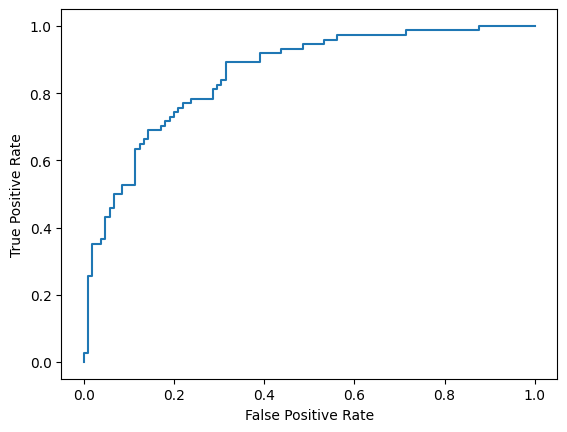

In [231]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [232]:
# Calculating the Geometric Means
gmeans = np.sqrt(tpr*(1-fpr))

In [233]:
# Finding the threshold
thresholds[np.argmax(gmeans)]

0.12343539429098926

## Use this if you are focusing on Recall:

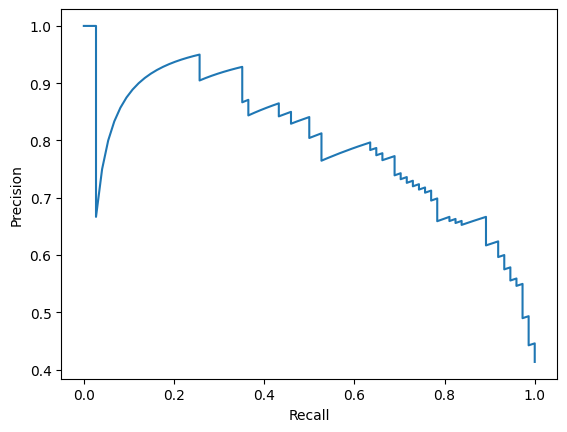

In [234]:
# We decided to look at the precision_recall curve as well to see the threshold between the 2 classes
precision, recall, _ = precision_recall_curve(y_test, pred_l_prob[:,1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We can see most Females and old people survived and people who paid the most fare also survived. 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Load your dataset into 'df'

# Define categorical and numerical features
categorical_features = ['categorical_feature']
numerical_features = ['numerical_feature_1', 'numerical_feature_2']
target = 'target_column'  # Replace with your target column name

# Create transformers
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_features', cat_transformer, categorical_features),
        ('numerical_features', num_transformer, numerical_features)
    ])

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features], df[target], test_size=0.3, random_state=1234)

# Define models and parameter grids
models = [
    ('KNN', KNeighborsClassifier(), {'model__n_neighbors': [3, 5, 7]}),
    ('Naive Bayes', GaussianNB(), {}),
    ('SVM', SVC(), {'model__C': [0.1, 1, 10]}),
    ('Logistic Regression', LogisticRegression(max_iter=1000), {}),
    ('Decision Tree', DecisionTreeClassifier(), {'model__max_depth': [None, 5, 10]})
]

# Loop through models
for name, model, param_grid in models:
    print(f"Model: {name}")
    
    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"Cross-Validation F1 Scores: {cv_scores}")
    print(f"Mean CV F1 Score: {cv_scores.mean()}")

    # Randomized hyperparameter tuning using RandomizedSearchCV
    knn_params ={'n_neighbors': range (3,300),'weights': ['uniform', 'distance'], 'metric':['euclidean','manhattan']}
    rs_knn=RandomizedSearchCV(knn,knn_params, n_iter=10, cv=5, scoring='precision')
    rs_knn.fit(X_train,y_train)
    rs_knn.best_estimator_

    knn_best = KNeighborsClassifier(n_neighbors=14, metric='euclidean', weights='distance' )
knn_best.fit(X_train,y_train)
pred_knn_best = knn_best.predict(X_test)

f1_score_knn = f1_score(pred_knn_best, y_test)
precision_knn = precision_score(pred_knn_best, y_test)
recall_knn = recall_score(pred_knn_best, y_test)
accuracy_knn = accuracy_score(pred_knn_best, y_test)

cv_scores_knn = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='precision')
print("Cross-validation scores for KNN: ", cv_scores_knn)

    randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=3, cv=5, scoring='f1_macro')
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    print(f"Best Parameters: {randomized_search.best_params_}")
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Test F1 Score: {f1}\n")
